2018 Edition

# Estimating Financial Risk through Monte Carlo Simulation
Risk analysis is part of every decision we make when faced with uncertainty, ambiguity, and variability. Indeed, even though we have unprecedented access to information, we can't accurately predict the future. In finance, there is a fair amount of uncertainty and risk involved with estimating the future value of financial products, due to the wide variety of potential outcomes. Monte Carlo simulation (also known as the Monte Carlo Method) allows inspecting many possible outcomes of the decision making process, and can be used to assess the impact of risk: this, in turns, allows for better decision-making under uncertainty.

## Goals
The main objectives we set for this Notebook are as follows:
1. Develop fundamental knowledge about Risk analysis
2. Understand Monte Carlo Simulation (MCS)
3. Apply Monte Carlo Simulation for predicting risk


## Steps
1. First, in section 1, we introduce the basics of MCS
2. In section 2, we work on a simple example to where we apply the MCS method
3. In section 3, we briefly summarize the main characteristics of the Monte Carlo Simulation (MCS) technique
4. In section 4, we overview the common distributions which are often used in MCS
5. In section 5, we work on a real use case, that focuses on estimating financial risk. We will use techniques such as featurization  (that is, generating additional features to improve model accuracy), linear regression, kernel density estimation, sampling distributions and so on ...

## Reference
This Notebook is inspired by Chapter 9 of the book [Advanced Analytics with Spark](http://shop.oreilly.com/product/0636920035091.do) by Josh Wills, Sandy Ryza, Sean Owen, and Uri Laserson. It is strongly suggested to read this Chapter to get a general idea of the topic of this Notebook.

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from math import sqrt
import statsmodels.api as sm
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.metrics import mean_squared_error as MSE
import scipy
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd

from os import listdir
from os.path import isfile, join
import sys

from datetime import datetime, timedelta
from itertools import islice

# default single-plot size
matplotlib.rcParams['figure.figsize'] = 10, 7

# 1. Introduction

## 1.1. Monte Carlo Simulation (MCS)
Monte Carlo simulation is a computerized mathematical technique that can be applied such that it is possible to account for risk in quantitative analysis and decision making. This technique is used in many different fields, such as R&D, risk management, portfolio management, pricing derivatives, strategic planning, project planning, cost modeling and many more.

In general, MCS is a technique that "converts" uncertainty on input variables of a model into **probability distributions**. By combining the distributions and randomly selecting values from them, it recalculates the simulated model many times, to determine the probability of the output.

Historically, this technique was first used by scientists working on the atomic bomb: it was named after Monte Carlo, the Monaco resort town renowned for its casinos.  Since its introduction in World War II, Monte Carlo simulation has been used to model a variety of physical and conceptual systems.

## 1.2. How does it work?
Monte Carlo simulation performs risk analysis by building models of possible results by *substituting a range of possible input values, that constitute uncertainty, into a statistical distribution*. It then computes possible outcomes repeatedly, each time using a different set of random values from the probability functions that "model" the input. Depending upon the number of random input variables and their distribution, a Monte Carlo simulation could involve thousands or tens of thousands of "rounds" before it is complete. When complete, *Monte Carlo simulation produces distributions of possible outcome values*.

By using probability distributions instead of actual input samples, it is possible to model more accurately uncertainty: different choices of distributions will yield different outputs.

# 2. Illustrative example

Imagine you are the marketing manager for a firm that is planning to introduce a new product. You need to estimate the first-year net profit from this product, which might depend on:

- Sales volume in units
- Price per unit (also called "Selling price")
- Unit cost
- Fixed costs

Net profit will be calculated as $Net Profit = Sales Volume* (Selling Price - Unit cost) - Fixed costs$.  Fixed costs (accounting for various overheads, advertising budget, etc.) are known to be \$ 120,000, which we assume to be deterministic. All other factors, instead, involve some uncertainty: *sales volume* (in units) can cover quite a large range, the *selling price* per unit will depend on competitor actions, which are hard to predict, and *unit costs* will also vary depending on vendor prices and production experience, for example.

Now, to build a risk analysis model, we must first identify the uncertain variables -- which are essentially random variables.  While there's some uncertainty in almost all variables in a business model, we want to focus on variables where the range of values is significant.

## 2.1. Unit sales and unit price

Based on a hypothetical market research you have done, you have beliefs that there are equal chances for the market to be `slow`, `normal`, or `hot`:

- In a "slow" market, you expect to sell 50,000 units at an average selling price of \$11.00 per unit
- In a "normal" market, you expect to sell 75,000 units, but you'll likely realize a lower average selling price of \$10.00 per unit
- In a "hot" market, you expect to sell 100,000 units, but this will bring in competitors, who will drive down the average selling price to \$8.00 per unit

### Question 1
<div class="alert alert-info">
Calculate the average units and the unit price that you expect to sell, which depend on the market state. Use the assumptions above to compute the expected quantity of products and their expected unit price. 
</div>


```python
average_unit = ...
average_price = ...
print("average unit:", average_unit)
print("average_price:", average_price)
```

In [3]:
sales_units_a = [50000, 75000, 100000]
prices = [11.0, 10.0, 8.0]

average_unit = sum(sales_units_a)/len(sales_units_a)
average_price = sum(prices)/len(prices)

print("average unit:", average_unit)
print("average_price:", average_price)

average unit: 75000.0
average_price: 9.666666666666666


## 2.2. Unit Cost

Another uncertain variable is Unit Cost. In our illustrative example, we assume that your firm's production manager advises you that unit costs may be anywhere from \$5.50 to \$7.50, with a most likely expected cost of \$6.50. In this case, the most likely cost can be considered as the average cost.

## 2.3. A Flawed Model: using averages to represent our random variables
Our next step is to identify uncertain functions -- also called functions of a random variable.  Recall that Net Profit is calculated as $Net Profit = Sales Volume * (Selling Price - Unit cost) - Fixed costs$.  However, Sales Volume, Selling Price and Unit Cost are all uncertain variables, so Net Profit is an uncertain function.

The simplest model to predict the Net Profit is using average of sales volume, average of selling price and average of unit cost for calculating. So, if only consider averages, we can say that the $Net Profit = 75,000*(9.66666666 - 6.5) - 120,000 \sim 117,500$.

However, as [Dr. Sam Savage](http://web.stanford.edu/~savage/faculty/savage/) warns, "Plans based on average assumptions will be wrong on average." The calculated result is far from the actual value: indeed, the **true average Net Profit** is roughly  \$93,000, as we will see later in the example.

### Question 2
#### Question 2.1
<div class="alert alert-info">
Write a function named `calNetProfit` to calculate the Net Profit using the average of sales volume, the average of selling price and the average of unit cost.
</div>

```python
def calNetProfit(average_unit, average_price, average_unitcost, fixed_cost):
    return ...

average_unitcost = ...
fixed_cost = ...
NetProfit = calNetProfit(...,...,...,...)
print("Net profit:", NetProfit)
```

In [4]:
def calNetProfit(sales_volume, price, unit_cost, fixed_cost):
    return (sales_volume * (price - unit_cost) - fixed_cost)

average_unitcost = 6.50
fixed_cost = 120000
NetProfit = calNetProfit(sales_volume = average_unit, 
                         price = average_price, 
                         unit_cost = average_unitcost, 
                         fixed_cost = fixed_cost)

print("Net profit:", NetProfit)

Net profit: 117499.99999999994


#### Question 2.2
<div class="alert alert-info">
Verify the warning message of Dr. Sam Savage by calculating the error of our estimated Net Profit using averages only. Recall that the true value is roughly \$93,000, so we are interested in:
<ul></ul>

$$ error = \frac{your\_value - true\_value}{true\_value}$$

<ul></ul>
Note also we are interested in displaying the error as a percentage.
<ul></ul>
Looking at the error we make, do you think that we can use the current model that only relies on averages?
</div>

```python
trueNetProfit = ...
error = (... - ...) / (...)
print("Error in percentage:", error * ...)
```

In [5]:
trueNetProfit = 93000
error = abs(NetProfit - trueNetProfit) / (trueNetProfit)
print("Error in percentage:", error * 100, "%")

Error in percentage: 26.344086021505316 %


<div class="alert alert-warning">
As already stated, a model based on the average of the observation does not perform well. The current model has an error too big to be used, we should introduce some risk.<br>
Moreover, the mean of a function is not generally equal to the function of the mean. 
</div>

## 2.4. Using the Monte Carlo Simulation method to improve our model
As discussed before, the selling price and selling volume both depend on the state of the market scenario (slow/normal/hot). So, the net profit is the result of two random variables: `market scenario` (which in turn determines `sales volumes` and `selling price`) and `unit cost`.

Now, let's assume (this is an *a-priori* assumption we make) that `market scenario` follows a discrete, uniform distribution and that `unit cost` also follows a uniform distribution. Then, we can compute directly the values for selling price and selling volumes based on the outcome of the random variable `market scenario`, as shown in Section 2.1.

From these a-priori distributions, in each run (or trial) of our Monte Carlo simulation, we can generate the sample value for each random variable and use it to calculate the Net Profit. The more simulation runs, the more accurate our results will be. For example, if we run the simulation 100,000 times, the average net profit will amount to roughly \$92,600. Every time we run the simulation, a different prediction will be output: the average of such predictions will consistently be less than \$117,500, which we predicted using averages only.

Note also that in this simple example, we generate values for the `market scenario` and `unit cost` independently: we consider them to be **independent random variables**. This means that the eventual (and realistic!) correlation between the `market scenario` and `unit cost` variables is ignored. Later, we will learn how to be more precise and account for dependency between random variables.


### Question 3
#### Question 3.1
<div class="alert alert-info">
Write a function named `get_sales_volume_price` that returns the sales volume and price based on the market scenario. In particular, the scenario can get one of three values:
<ul>
  <li>0: Slow market</li>
  <li>1: Normal market</li>
  <li>2: Hot market</li>
</ul>  

The return value is a tuple in the form: `(sales_volume, price)`
</div>

```python
# Get sales volume and  price based on market scenario
# the function returns a tuple of (sales_volume, price)
def get_sales_volume_price(scenario):
    # Slow market
    if scenario == 0:
        return (...,...)
    # Normal market
    if ...
    # Hot market
    if ...
```

In [6]:
# Get sales volume and  price based on market scenario
# the function returns a tuple of (sales_volume, price)
def get_sales_volume_price(scenario):
    # Slow market
    if scenario == 0:
        return (sales_units_a[0], prices[0])
    # Normal market
    if scenario == 1:
        return (sales_units_a[1], prices[1])
    # Hot market
    if scenario == 2:
        return (sales_units_a[2], prices[2])

# check correctness of the returned values
print([get_sales_volume_price(x) for x in range(3)])

[(50000, 11.0), (75000, 10.0), (100000, 8.0)]


#### Question 3.2
<div class="alert alert-info">
Run 100,000 Monte Carlo simulations and calculate the average net profit they produce. Then, compare the result to the "average model" we used in the previous questions (the one we called "flawed" model). Put your comments about the discrepancies between a simplistic model, and the more accurate MCS approach.  
<ul></ul>
Note that in each iteration, the `unit_cost` and `market_scenario` are generated according to their distributions. Also, recall what we have seen in Section 2.2: your firm account manager helped you with some research, to determine the variability of your random variables.  
</div>


<div class="label label-success">HINT</div>  

Function `uniform(a,b)` in module `random` generates a number $a<=c<=b$, which is drawn from a uniform distribution.  

Function `randint(a,b)` helps you generating an integer number $a<=c<=b$

```python
import random

total = 0.0
num_simulation = 100000
for i in range(0,num_simulation):
    unit_cost = ...
    market_scenario = ...
    sales_volume, price = get_sales_volume_price(...)
    netProfit = ...
    total = ...

print("average net profit:", ...)
```

In [7]:
import random

total = 0.0
num_simulation = 100000
simulations = []
for i in range(num_simulation):
    unit_cost = random.uniform(5.50,7.50)
    market_scenario = random.randint(0,2)
    sales_volume, price = get_sales_volume_price(market_scenario)
    netProfit = calNetProfit(sales_volume = sales_volume, 
                             price = price, 
                             unit_cost = unit_cost, 
                             fixed_cost = fixed_cost)
    total += netProfit
    simulations.append(netProfit)

avgNetProfit = total/num_simulation
error = abs(avgNetProfit - trueNetProfit) / (trueNetProfit)

print("Average net profit:", avgNetProfit)
print("Error in percentage:", error * 100, "%")

Average net profit: 92111.56139427192
Error in percentage: 0.9553103287398699 %


<div class="alert alert-warning" align="justify">
As expected, the Monte Carlo simulations return an average value oscillating between 92000 and 93000. This value is lower than the one obtained by averaging the random variables and its better because it takes into consideration the expected distribution of the model's parameters.<br>
However it still has one limitation: it does not consider the possible correlation between the random variables.<br>
The difference between the results obtained using the different approaches as been plotted on the pdf of the net profit (blue line: MC simulations; red line: variables average).
</div>

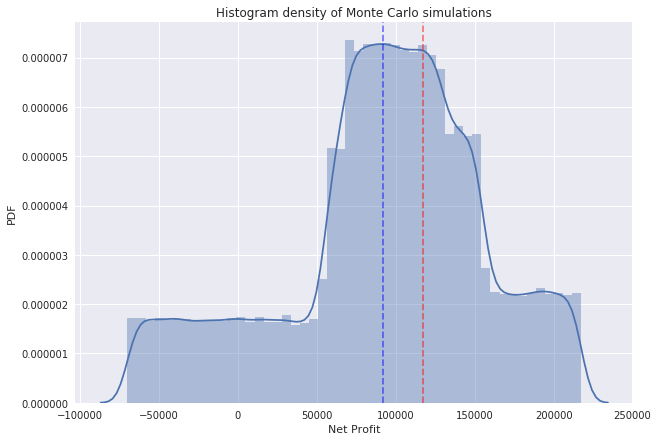

In [8]:
sns.set()
sns.set_context("notebook")
sns.distplot(simulations, kde = True)
plt.axvline(x=avgNetProfit, color='b', ls='--', alpha=0.5)
plt.axvline(x=NetProfit, color='r', ls='--', alpha=0.5)
plt.title("Histogram density of Monte Carlo simulations")
plt.xlabel("Net Profit")
plt.ylabel("PDF")
plt.show()

# 3. A brief summary of the Monte Carlo Simulation (MCS) technique

- A MCS allows several inputs to be used at the same time to compute the probability distribution of one or more outputs
- Different types of probability distributions can be assigned to the inputs of the model, depending on any *a-priori* information that is available. When the distribution is completely unknown, a common technique is to use a distribution computed by finding the best fit to the data you have
- The MCS method is also called a **stochastic method** because it uses random variables. Note also that the general assumption is for input random variables to be independent from each other. When this is not the case, there are techniques to account for correlation between random variables.
- A MCS generates the output as a range instead of a fixed value and shows how likely the output value is to occur in that range. In other words, the model outputs a probability distribution.

# 4. Common distributions used in MCS
In what follows, we summarize the most common probability distributions that are used as *a-priori* distributions for input random variables:

- *Normal/Gaussian Distribution*: this is a continuous distribution applied in situations where the mean and the standard deviation of a given input variable are given, and the mean represents the most probable value of the variable. In other words, values "near" the mean are most likely to occur.  This is symmetric distribution, and it is not bounded in its co-domain. It is very often used to  describe natural phenomena, such as people’s heights, inflation rates, energy prices, and so on and so forth. An illustration of a normal distribution is given below:
![normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/320px-Normal_Distribution_PDF.svg.png)

- *Lognormal Distribution*: this is a distribution which is appropriate for variables taking values in the range $[0, \infty]$. Values are positively skewed, not symmetric like a normal distribution.  Examples of variables described by some lognormal distributions include, for example, real estate property values, stock prices, and oil reserves. An illustration of a lognormal distribution is given below:
![log_normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/PDF-log_normal_distributions.svg/320px-PDF-log_normal_distributions.svg.png) 

- *Triangular Distribution*: this is a continuous distribution with fixed minimum and maximum values. It is bounded by the minimum and maximum values and can be either symmetrical (the most probable value = mean = median) or asymmetrical. Values around the most likely value (e.g. the mean) are more likely to occur.  Variables that could be described by a triangular distribution include, for example, past sales history per unit of time and inventory levels. An illustration of a triangular distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Triangular_distribution_PMF.png/320px-Triangular_distribution_PMF.png)

- *Uniform Distribution*: this is a continuous distribution bounded by known minimum and maximum values. In contrast to the triangular distribution, the likelihood of occurrence of the values between the minimum and maximum is the same. In other words, all values have an equal chance of occurring, and the distribution is simply characterized by the minimum and maximum values. Examples of variables that can be described by a uniform distribution include manufacturing costs or future sales revenues for a new product. An illustration of the uniform distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Uniform_Distribution_PDF_SVG.svg/320px-Uniform_Distribution_PDF_SVG.svg.png)

- *Exponential Distribution*: this is a continuous distribution used to model the time that pass between independent occurrences, provided that the rate of occurrences is known. An example of the exponential distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/320px-Exponential_pdf.svg.png)

- *Discrete Distribution* : for this kind of distribution, the "user" defines specific values that may occur and the likelihood of each of them.  An example might be the results of a lawsuit: 20% chance of positive verdict, 30% change of negative verdict, 40% chance of settlement, and 10% chance of mistrial.


# 5. A real use case: estimating the financial risk of a portfolio of stocks
We hope that by now you have a good understanding about Monte Carlo simulation. Next, we apply this method to a real use case: *financial risk estimation*.

Imagine that you are an investor on the stock market. You plan to buy some stocks and you want to estimate the maximum loss you could incur after two weeks of investing. This is the quantity that the financial statistic "Value at Risk" (VaR) seeks to measure. [VaR](https://en.wikipedia.org/wiki/Value_at_risk) is defined as a measure of investment risk that can be used as a reasonable estimate of the maximum probable loss for a value of an investment portfolio, over a particular time period. A VaR statistic depends on three parameters: a portfolio, a time period, and a confidence level. A VaR of 1 million dollars with a 95% confidence level over two weeks, indicates the belief that the portfolio stands only a 5% chance of losing more than 1 million dollars over two weeks. VaR has seen widespread use across financial services organizations. This statistic plays a vital role in determining how much cash investors must hold to meet the credit ratings that they seek. In addition, it is also used to understand the risk characteristics of large portfolios: it is a good idea to compute the VaR before executing trades, such that it can help take informed decisions about investments. 

Our goal is calculating VaR of two weeks interval with 95% confidence level and the associated [VaR confidence interval](http://www.investopedia.com/ask/answers/041615/whats-difference-between-confidence-level-and-confidence-interval-value-risk-var.asp).


## 5.1. Terminology
In this use case, we will use some terms that might require a proper definition, given the domain. This is what we call the *Domain Knowledge*.

- **Instrument**: A tradable asset, such as a bond, loan, option, or stock investment. At any particular time, an instrument is considered to have a value, which is the price for which it can be sold. In the use case of this notebook, instruments are stock investments.
- **Portfolio**: A collection of instruments owned by a financial institution. 
- **Return**: The change in an instrument or portfolio’s value over a time period. 
- **Loss**: A negative return. 
- **Index**: An imaginary portfolio of instruments. For example, the NASDAQ Composite index includes about 3,000 stocks and similar instruments for major US and international companies. 
- **Market factor**: A value that can be used as an indicator of macro aspects of the financial climate at a particular time. For example, the value of an index, the Gross Domestic Product of the United States, or the exchange rate between the dollar and the euro. We will often refer to market factors as just factors.

## 5.2. The context of our use case
We have a list of instruments that we plan to invest in. The historical data of each instrument has been collected for you. For simplicity, assume that the returns of instruments at a given time, depend on 4 market factors only: 

- GSPC value
- IXIC value 
- The return of crude oil
- The return of treasury bonds

Our goal is building a model to predict the loss after two weeks' time interval with confidence level set to 95%.

As a side note, it is important to realize that the approach presented in this Notebook is a simplified version of what would happen in a real Financial firm. For example, the returns of instruments at a given time often depend on more than 4 market factors only! Moreover, the choice of what constitute an appropriate market factor is an art!

## 5.3. The Data
The stock data can be downloaded (or scraped) from Yahoo! by making a series of REST calls. The data includes multiple files. Each file contains the historical information of each instrument that we want to invest in. The data is in the following format (with some samples):
```
Date, Open, High, Low, Close, Volume, Adj Close
2016-01-22,66.239998,68.07,65.449997,67.860001,137400,67.860001
2016-01-21,65.410004,66.18,64.459999,65.050003,148000,65.050003
2016-01-20,64.279999,66.32,62.77,65.389999,141300,65.389999
2016-01-19,67.720001,67.989998,64.720001,65.379997,178400,65.379997
```

The data of GSPC and IXIC values (our two first market factors) are also available on Yahoo! and use the very same format. 

The crude oil and treasure bonds data is collected from investing.com, and has a different format, as shown below (with some samples):
```
Date    Price   Open    High    Low     Vol.    Change %
Jan 25, 2016    32.17   32.36   32.44   32.10   -       -0.59%
Jan 24, 2016    32.37   32.10   32.62   31.99   -       0.54%
Jan 22, 2016    32.19   29.84   32.35   29.53   -       9.01%
Jan 21, 2016    29.53   28.35   30.25   27.87   694.04K 11.22%
Jan 20, 2016    26.55   28.33   28.58   26.19   32.11K  -6.71%
Jan 19, 2016    28.46   29.20   30.21   28.21   188.03K -5.21%
```

In our use case, the factors' data will be used jointly to build a statistical model: as a consequence, we first need to preprocess the data to proceed.

## 5.4. Data preprocessing
In this Notebook, all data files have been downloaded for you, such that you can focus on pre-processing. Next, we will:

  - Read the factor data files which are in two different formats, process and merge them together
  - Read the stock data and pre-process it
  - Trim all data into a specific time region
  - Fill in the missing values
  - Generate the data of returns in each two weeks' time interval window

  
### Factor data pre-processing

We need two functions to read and parse data from Yahoo! and Investing.com respectively. We are interested only in information about the time and the corresponding returns of a factor or an instrument: as a consequence, we will project away many columns of our RAW data, and keep only the information we are interested in.

The 3000-instrument and the 4-factor history are small enough to be read and processed locally: we do not need to use the power of parallel computing to proceed. Note that this is true also for larger cases with hundreds of thousands of instruments and thousands of factors. The need for a distributed system like Spark comes in when actually **running** the Monte Carlo simulations, which can require massive amounts of computation on each instrument. 

### Question 4
#### Question 4.1
<div class="alert alert-info">
Write a function named `readInvestingDotComHistory` to parse data from investing.com based on the format specified above (see Section 5.3). Recall that we use two factors here: one that is related to the price of crude oil, one that is related to some specific US bonds. 

<ul></ul>

Print the first 5 entries of the first factor (crude oil price) in the parsed data.

<ul></ul>

Note that we are only interested in the date and price of stocks.

</div>

<div class="label label-success">HINT</div>  
You can parse a string to `datetime` object by using the function `strptime(<string>, <dtime_format>)`. In this case, the datetime format is `"%b %d, %Y"`. For more information, please follow this [link](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior).

In the next cell, we simply copy data from our HDFS cluster (that contains everything we need for this Notebook) to the instance (a Docker container) running your Notebook. This means that you will have "local" data that you can process without using Spark. Note the folder location: find and verify that you have correctly downloaded the files!

In [9]:
! [ -d monte-carlo-risk ] || (echo "Downloading prepared data from HDFS. Please wait..." ; hdfs dfs -copyToLocal /datasets/monte-carlo-risk . ; echo "Done!";)

```python
from datetime import datetime
from datetime import timedelta
from itertools import islice
%matplotlib inline
import numpy as np
import statsmodels.api as sm

base_folder = "monte-carlo-risk/"

factors_folder= base_folder + "factors/"

# read data from local disk
def readInvestingDotComHistory(fname):
    def process_line(line):
        cols = line.split(...)
        date = datetime.strptime(..., ...)
        value = float(...)
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header....
        return list(map(process_line , content))

factor1_files = ['crudeoil.tsv', 'us30yeartreasurybonds.tsv']
factor1_files = map(lambda fn: factors_folder + fn, factor1_files)
factors1 = [readInvestingDotComHistory(f) for f in factor1_files]

print(factors1...)
```

In [10]:
base_folder = "monte-carlo-risk/"

factors_folder= base_folder + "factors/"

def getRecords(fname, separator=",", valueColumn=4, dateColumn=0, dateFormat="%Y-%m-%d"):
    def process_line(line):
        cols = line.split(separator)
        date = datetime.strptime(cols[dateColumn], dateFormat)
        value = float(cols[valueColumn])
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[-1 : 0 : -1]
        return list(map(process_line , content))

factor1_files = ['crudeoil.tsv', 'us30yeartreasurybonds.tsv']
factor1_files = map(lambda fn: factors_folder + fn, factor1_files)
factors1 = [getRecords(f, "\t", 1, dateFormat="%b %d, %Y") for f in factor1_files]

print("First 5 entries of the crude oil price factor:")
for rec in factors1[0][:5]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))

First 5 entries of the crude oil price factor:
Date: 2006-01-26	Value: 66.26
Date: 2006-01-27	Value: 67.76
Date: 2006-01-30	Value: 68.35
Date: 2006-01-31	Value: 67.92
Date: 2006-02-01	Value: 66.56


Now, the data structure `factors1` is a list, containing data that pertains to two (out of a total of four) factors that influence the market, as obtained by investing.com. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. From now on, we call these elements "**records**" or "**entries**". Visually, `factors1` looks like this:

| 0 (crude oil) | 1 (US bonds)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


#### Question 4.2
<div class="alert alert-info">
Write a function named `readYahooHistory` to parse data from yahoo.com based on its format, as described in Section 5.3.  
<ul></ul>
Print the first 5 entries of the first factor (namely GSPC). Comment the time range of the second batch of data we use in our Notebook.  
<ul></ul>

Note that we are only interested in the date and price of stocks.
</div>

<div class="label label-danger">NOTE</div> The datetime format now is in a different format than the previous one.

<div class="label label-success">HINT</div> Use a terminal (or put the bash commands inline in your Notebook) to list filenames in your local working directory to find and have a look at your local files.

```python
# read data from local disk
def readYahooHistory(fname):
    def process_line(line):
        ...
        ...
        ...
        ...
    
    with open(fname) as f:
        ...
        ...
        ...
        ...
    

factor2_files = [..., ...]
factor2_files = map(lambda fn: factors_folder + fn, factor2_files)

factors2 = [readYahooHistory(f) for f in factor2_files]

print(factors2[0][:5])
```

In [11]:
factor2_files = ["GSPC.csv", "IXIC.csv"]
factor2_files = map(lambda fn: factors_folder + fn, factor2_files)

factors2 = [getRecords(f) for f in factor2_files]

print("First 5 entries of the GSPC factor:")
for rec in factors2[0][:5]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))

First 5 entries of the GSPC factor:
Date: 1950-01-03	Value: 16.66
Date: 1950-01-04	Value: 16.85
Date: 1950-01-05	Value: 16.93
Date: 1950-01-06	Value: 16.98
Date: 1950-01-09	Value: 17.08


In [12]:
# check market factors values
print("-- Crude oil --")
print("First date: " + factors1[0][0][0].strftime("%Y-%m-%d"))
print("Last date: " + factors1[0][-1][0].strftime("%Y-%m-%d"))
print("-- Treasury bonds --")
print("First date: " + factors1[1][0][0].strftime("%Y-%m-%d"))
print("Last date: " + factors1[1][-1][0].strftime("%Y-%m-%d"))
print("-- GSPC --")
print("First date: " + factors2[0][0][0].strftime("%Y-%m-%d"))
print("Last date: " + factors2[0][-1][0].strftime("%Y-%m-%d"))
print("-- IXIC --")
print("First date: " + factors2[1][0][0].strftime("%Y-%m-%d"))
print("Last date: " + factors2[1][-1][0].strftime("%Y-%m-%d"))

-- Crude oil --
First date: 2006-01-26
Last date: 2016-01-25
-- Treasury bonds --
First date: 2008-02-12
Last date: 2016-01-25
-- GSPC --
First date: 1950-01-03
Last date: 2016-01-22
-- IXIC --
First date: 1971-02-05
Last date: 2016-01-22


<div class="alert alert-warning" align="justify">
In the previous cell we showed the oldest and the most recent date for each market factor. It is clear that factor's entries are taken on different time interval, the crude oil data has 10 years of history, the treasury bonds has only 8 years of records and the GSPC and IXIC have respectively 66 and 45 years of span.<br>
Fortunately, the final year of every factor is 2016 but, in order to make estimations, it could be necessary to truncate the entries of all the factors based on the shortest history, from 2008 to 2016.
</div>

Now, the data structure `factors2` is again list, containing data that pertains to the next two (out of a total of four) factors that influence the market, as obtained by Yahoo!. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. Visually, `factors2` looks like this:

| 0 (GSPC) | 1 (IXIC)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


### Stock data pre-processing

Next, we prepare the data for the instruments we consider in this Notebook (i.e., the stocks we want to invest in). 

#### Question 4.3

<div class="alert alert-info">
In this Notebook, we assume that we want to invest on the first 35 stocks out of the total 3000 stocks present in our datasets.

<ul></ul>

Load and prepare all the data for the considered instruments (the first 35 stocks) which have historical information for more than 5 years. This means that all instruments with less than 5 years of history should be removed.

</div>

<div class="label label-success">HINT</div> we suggest to open a terminal window (not on your local machine, but the Notebook terminal that you can find on the Jupyter dashboard) and visually check the contents of the directories holding our dataset, if you didn't do this before! Have a look at how stock data is organized!

```python
from os import listdir
from os.path import isfile, join

stock_folder = base_folder + 'stocks'

def process_stock_file(fname):
    try:
        return ...
    except Exception as e:
        raise e
        return None



# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]

# assume that we invest only the first 35 stocks (for faster computation)
files = files[:35]

# read each line in each file, convert it into the format: (date, value)
rawStocks = [... for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument: ...  , rawStocks))

# For testing, print the first 5 entry of the first stock
print(rawStocks[0][:5])

```

In [13]:
stock_folder = base_folder + 'stocks'

def process_stock_file(fname):
    try:        
        return getRecords(fname)
    except Exception as e:
        raise e
        return None

# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in sorted(listdir(stock_folder)) if isfile(join(stock_folder, f))]

# assume that we invest only the first 35 stocks (for faster computation)
files = files[:35]

# read each line in each file, convert it into the format: (date, value)
rawStocks = [process_stock_file(f) for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument: len(instrument) >= number_of_years * 260, rawStocks))

# For testing, print the first 5 entries of the first stock
print(35 - len(rawStocks), "instruments have been removed because they had too short history data")
print("First 5 entries of the first instrument:")
for rec in rawStocks[0][:5]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))

7 instruments have been removed because they had too short history data
First 5 entries of the first instrument:
Date: 2005-09-27	Value: 19.299999
Date: 2005-09-28	Value: 20.5
Date: 2005-09-29	Value: 20.209999
Date: 2005-09-30	Value: 21.01
Date: 2005-10-03	Value: 21.5


### Time alignment for our data
Different types of instruments may trade on different days, or the data may have missing values for other reasons, so it is important to make sure that our different histories align. First, we need to trim all of our time series to the same region in time. Then, we need to fill in missing values. To deal with time series that have missing values at the start and end dates in the time region, we simply fill in those dates with nearby values in the time region.

#### Question 4.4
<div class="alert alert-info">
Assume that we only focus on the data from 23/01/2009 to 23/01/2014. Write a function named `trimToRegion` to select only the records in that time interval. 

<ul></ul>

**Requirements**: after processing, each instrument $i$ has a list of records: $[r_0, r_2,...,r_{m_i}]$ such that $r_0$ and $r_{m_i}$ are assigned, respectively, the first and the last values corresponding to the extremes of the given time interval. For example: $r_0$ should contain the value at date 23/01/2009.
</div>

```python
# note that the data of crude oil and treasury is only available starting from 26/01/2006 
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

def trimToRegion(history, start, end):
    def isInTimeRegion(entry):
        (date, value) = entry
        return date >= ... and date <= ...

    # only select entries which are in the time region
    trimmed = list(filter( ..., ...))
    
    # if the data has incorrect time boundaries, add time boundaries
    if trimmed[0][0] != start:
        trimmed.insert(0, (..., trimmed[0][1]))
    if trimmed[-1][0] != end:
        trimmed.append((..., trimmed[-1][1]))
    return trimmed
    
# test our function
trimmedStock0  = trimToRegion(rawStocks[0], start, end)
# the first 5 records of stock 0
print(trimmedStock0[:5])
# the last 5 records of stock 0
print(trimmedStock0[-5:])

assert(trimmedStock0[0][0] == start), "the first record must contain the price in the first day of time interval"
assert(trimmedStock0[-1][0] == end), "the last record must contain the price in the last day of time interval"
```

In [14]:
# note that the data of crude oil and treasury is only available starting from 26/01/2006 
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

def trimToRegion(history, start, end):
    def isInTimeRegion(entry):
        (date, value) = entry
        return date >= start and date <= end

    # only select entries which are in the time region
    trimmed = list(filter(isInTimeRegion, history))
    
    # if the data has incorrect time boundaries, add time boundaries
    if trimmed[0][0] != start:
        trimmed.insert(0, (start, trimmed[0][1]))
    if trimmed[-1][0] != end:
        trimmed.append((end, trimmed[-1][1]))
    return trimmed
    
# test our function
trimmedStock0  = trimToRegion(rawStocks[0], start, end)

# the first 5 records of stock 0
print("First 5 entries of the first trimmed stock:")
for rec in trimmedStock0[:5]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))

# the last 5 records of stock 0
print("------------------------------------------")
print("Last 5 entries of the first trimmed stock:")
for rec in trimmedStock0[-5:]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))

assert(trimmedStock0[0][0] == start), "the first record must contain the price in the first day of time interval"
assert(trimmedStock0[-1][0] == end), "the last record must contain the price in the last day of time interval"

First 5 entries of the first trimmed stock:
Date: 2009-01-23	Value: 7.82
Date: 2009-01-26	Value: 7.7
Date: 2009-01-27	Value: 6.71
Date: 2009-01-28	Value: 7.3
Date: 2009-01-29	Value: 6.47
------------------------------------------
Last 5 entries of the first trimmed stock:
Date: 2014-01-16	Value: 29.34
Date: 2014-01-17	Value: 30.02
Date: 2014-01-21	Value: 30.66
Date: 2014-01-22	Value: 31.200001
Date: 2014-01-23	Value: 31.35


### Dealing with missing values
We expect that we have the price of instruments and factors **in each business day**. Unfortunately, there are many missing values in our data: this means that we miss data for some days, e.g. we have data for the Monday of a certain week, but not for the subsequent Tuesday. So, we need a function that helps filling these missing values.

Next, we provide to you the function to fill missing value: read it carefully!

In [15]:
def fillInHistory(history, start, end, percMissValues=False):
    curr = history
    filled = []
    idx = 0
    curDate = start
    numEntries = len(history)
    nDays = 0
    while curDate < end:
        
        # if the next entry is in the same day
        # or the next entry is at the weekend
        # but the curDate has already skipped it and moved to the next monday
        # (only in that case, curr[idx + 1][0] < curDate )
        # then move to the next entry
        while idx + 1 < numEntries and curr[idx + 1][0] <= curDate:
            idx +=1

        # only add the last value of instrument in a single day
        # check curDate is weekday or not
        # 0: Monday -> 5: Saturday, 6: Sunday
        if curDate.weekday() < 5:

            filled.append((curDate, curr[idx][1]))
            # move to the next business day
            curDate += timedelta(days=1)

            nDays += 1
            
        # skip the weekends
        elif curDate.weekday() >= 5:
            # if curDate is Sat, skip 2 days, otherwise, skip 1 day
            curDate += timedelta(days=(7-curDate.weekday()))
    
    if percMissValues:
        return (nDays - numEntries) * 100 / nDays
    return filled

# test our function
filledStock0  = fillInHistory(trimmedStock0, start, end + timedelta(days=1))

# the first 5 records of stock 0
print("First 5 entries of the first trimmed stock:")
for rec in filledStock0[:5]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))

# the last 5 records of stock 0
print("------------------------------------------")
print("Last 5 entries of the first trimmed stock:")
for rec in filledStock0[-5:]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))

First 5 entries of the first trimmed stock:
Date: 2009-01-23	Value: 7.82
Date: 2009-01-26	Value: 7.7
Date: 2009-01-27	Value: 6.71
Date: 2009-01-28	Value: 7.3
Date: 2009-01-29	Value: 6.47
------------------------------------------
Last 5 entries of the first trimmed stock:
Date: 2014-01-17	Value: 30.02
Date: 2014-01-20	Value: 30.02
Date: 2014-01-21	Value: 30.66
Date: 2014-01-22	Value: 31.200001
Date: 2014-01-23	Value: 31.35


<div class="alert alert-warning" align="justify">
Before proceeding it could be good to have a measure of the quality of the input data by computing the percentage of missing values of each instrument. In order to do so, we made a small edit to the function (added the percMissValues boolean parameter).
</div>

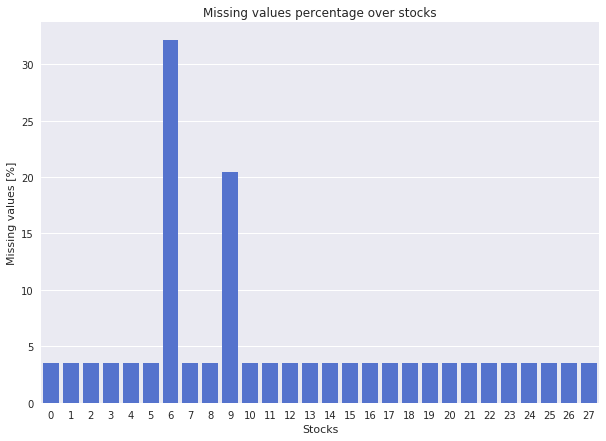

In [16]:
# compute missing values percentage for each stock
stocksMissingPerc = list(map(lambda stock: \
                        fillInHistory(
                            trimToRegion(stock, start, end), 
                        start, end + timedelta(days=1), percMissValues=True), 
                    rawStocks))

# display the results in a bar plot
sns.set_context("notebook")
sns.barplot(x = np.arange(len(stocksMissingPerc)), 
            y = stocksMissingPerc,
            color = 'royalblue')
plt.title("Missing values percentage over stocks")
plt.xlabel("Stocks")
plt.ylabel("Missing values [%]")
plt.show()

<div class="alert alert-warning" align="justify">
The percentage of missing values is not too high for almost all the stocks. Moreover, it is clear that most of the stocks have the same missing values percentage therefore it could be possible that histories are missing the same dates and those dates may be public holidays that should not be considered anyway.<br>
In conclusion, even if the plot shows a non-zero percentage of missing values, there is an high probability that input data are effectively clean or, at least, cleaner than it seems.<br><br>

The only exceptions between the stocks, are the ones with indexes 6 and 9: they present great percentages of missing values, respectively 32.1 % and 20.4 %.<br>
In order to understand this difference, let's analize the price values over time, also called stock trend.
</div>

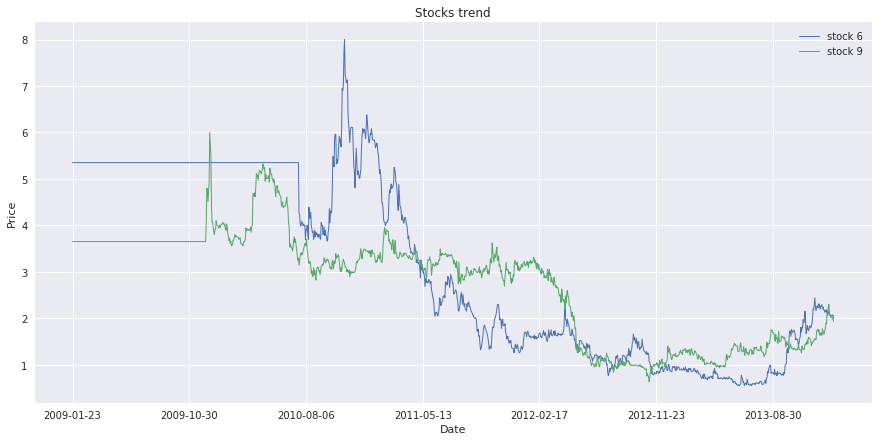

In [17]:
# process stocks 6 and 9
fillTrimStock6 = fillInHistory(trimToRegion(rawStocks[6], start, end), start, end + timedelta(days=1))
fillTrimStock9 = fillInHistory(trimToRegion(rawStocks[9], start, end), start, end + timedelta(days=1))

# plot the trends
plt.figure(figsize=(15,7))
plt.plot([x[1] for x in fillTrimStock6], lw=1, label="stock 6")
plt.plot([x[1] for x in fillTrimStock9], lw=1, label="stock 9")

# put dates on the x axis
locs, _ = plt.xticks()
locs = locs[1:-1]
labels = [fillTrimStock6[int(i)][0].strftime("%Y-%m-%d") for i in list(locs)]
plt.xticks(locs, labels)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stocks trend")
plt.legend()
plt.show()

<div class="alert alert-warning" align="justify">
The trends show clear signs of missing dates that are represented by horizontal lines. The most important line to notice is the initial one, it tells us that there is a big hole in the data and so the stock selection process went wrong.<br><br>

A first analysis of the code shows that we only filtered out the stocks containing more than approximately 5 years of records, but this gives no guarantees regarding the time region of those records.<br>
For now, we just remove the dirty stocks and, in future stocks selections, we will add a filter based on start and end dates of the entries.
</div>

In [18]:
rawStocks = rawStocks[:6] + rawStocks[7:9] + rawStocks[10:]

<div class="alert alert-warning" align="justify">
The same analysis of missing values should be applied to the factors data.
</div>

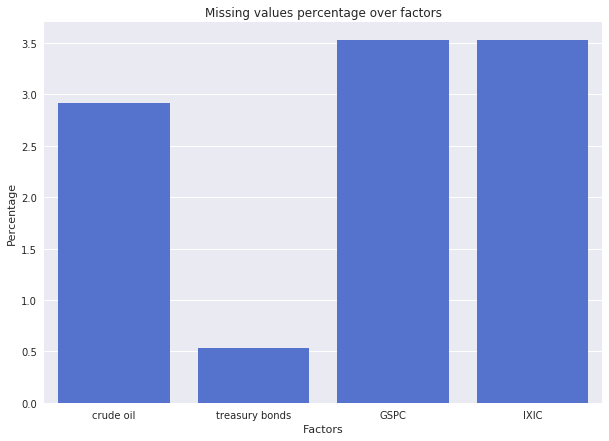

In [19]:
# merge the two factors lists
allfactors = factors1 + factors2

# compute missing values percentage for each factor
factorsMissingPerc = list(map(lambda factor: \
                        fillInHistory(
                            trimToRegion(factor, start, end), 
                        start, end + timedelta(days=1), percMissValues=True), 
                    allfactors))

# display the results in a bar plot
sns.set_context("notebook")
sns.barplot(x = np.arange(len(factorsMissingPerc)), 
            y = factorsMissingPerc,
            color = 'royalblue')
plt.title("Missing values percentage over factors")
plt.xlabel("Factors")
plt.ylabel("Percentage")
factorsNames = ["crude oil", "treasury bonds", "GSPC", "IXIC"]
plt.xticks(np.arange(4), factorsNames)
plt.show()

<div class="alert alert-warning" align="justify">
Factors histories have a low percentage of missing values, in particular, crude oil, GSPC and IXIC have a value very close to the stocks data, therefore the same assumption about public holidays can be made. Treasury bonds present a very low number of missing values, probably due to the fact that this market factor depends less on the nature of the day: either holiday or working day.
</div>

```python
#print rawStocks[0]

# trim into a specific time region
# and fill up the missing values
stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(..., ..., ...), 
            start, end), 
        rawStocks))



# merge two factors, trim each factor into a time region
# and fill up the missing values
allfactors = factors1 + factors2
factors = list(map(
            ..., 
            allfactors
            ))
            
# test our code
print("the first 5 records of stock 0:", stocks[0][:5], "\n")
print("the last 5 records of stock 0:", stocks[0][-5:], "\n")
print("the first 5 records of factor 0:", factors[0][:5], "\n")
print("the first 5 records of factor 0:", factors[0][-5:], "\n")
```

In [20]:
#print rawStocks[0]

# trim into a specific time region
# and fill up the missing values
stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end + timedelta(days=1)), 
        rawStocks))
       
# trim each factor into a time region
# and fill up the missing values
factors = list(map(lambda factor: \
            fillInHistory(
                trimToRegion(factor, start, end), 
            start, end + timedelta(days=1)),
          allfactors))
    
# test our code
print("the first 5 records of stock 0:")
for rec in stocks[0][:5]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))
print("the last 5 records of stock 0:")
for rec in stocks[0][-5:]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))
print("the first 5 records of factor 0:")
for rec in factors[0][:5]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))
print("the first 5 records of factor 0:")
for rec in factors[0][-5:]:
    print("Date: " + rec[0].strftime("%Y-%m-%d") + "\tValue: " + str(rec[1]))

the first 5 records of stock 0:
Date: 2009-01-23	Value: 7.82
Date: 2009-01-26	Value: 7.7
Date: 2009-01-27	Value: 6.71
Date: 2009-01-28	Value: 7.3
Date: 2009-01-29	Value: 6.47
the last 5 records of stock 0:
Date: 2014-01-17	Value: 30.02
Date: 2014-01-20	Value: 30.02
Date: 2014-01-21	Value: 30.66
Date: 2014-01-22	Value: 31.200001
Date: 2014-01-23	Value: 31.35
the first 5 records of factor 0:
Date: 2009-01-23	Value: 46.47
Date: 2009-01-26	Value: 45.73
Date: 2009-01-27	Value: 41.58
Date: 2009-01-28	Value: 42.16
Date: 2009-01-29	Value: 41.44
the first 5 records of factor 0:
Date: 2014-01-17	Value: 94.37
Date: 2014-01-20	Value: 93.93
Date: 2014-01-21	Value: 94.99
Date: 2014-01-22	Value: 96.73
Date: 2014-01-23	Value: 97.32


<div class="alert alert-warning" align="justify">
In order to be sure about the absence of anomalies in the data let's plot the factors trend.
</div>

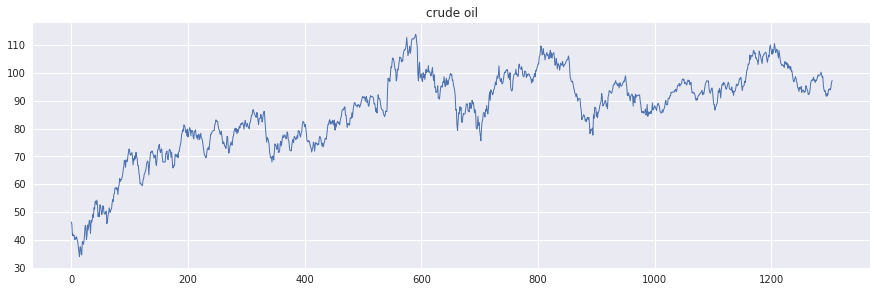

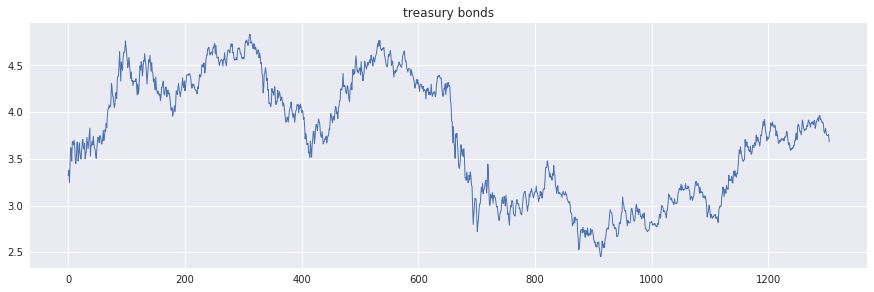

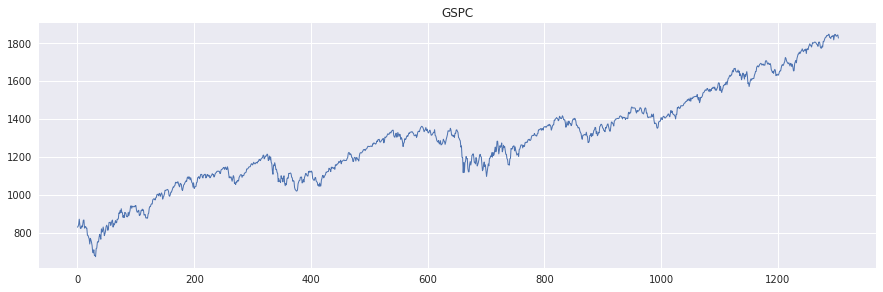

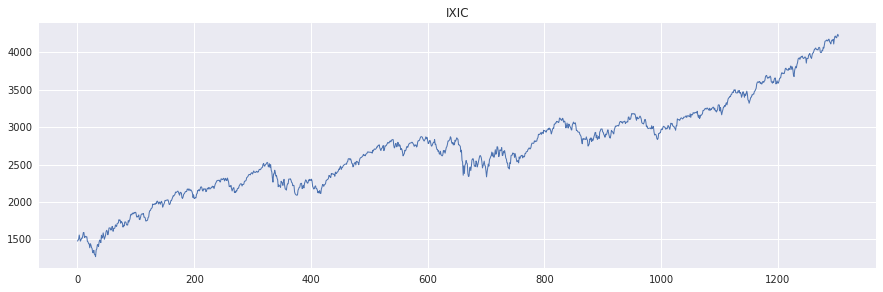

In [21]:
for i in range(len(factors)):
    plt.figure(figsize=(15, 4.5))
    plt.plot([x[1] for x in factors[i]], lw=1)
    plt.title(factorsNames[i])
    plt.show()

<div class="alert alert-warning" align="justify">
There seems to be no further anomalies in the factors trend. The last two plots, GSPC and IXIC, have a very similar shape even if in different values range, this could lead us to think that the two factors have great correlation, further investigations will be presented in the correlation section.
</div>

Recall that Value at Risk (VaR) deals with **losses over a particular time horizon**. We are not concerned with the absolute prices of instruments, but how those prices **change over** a given period of time. In our project, we will set that length to two weeks: we use the sliding window method to transform time series of prices into an overlapping sequence of price change over two-week intervals.

The figure below illustrates this process. The returns of market factors after each two-week interval is calculated in the very same way.

![](https://dl.dropboxusercontent.com/s/r9ucsicichb6gjh/two-week-time-interval.svg)

In [22]:
def buildWindow(seq, k=2):
    "Returns a sliding window (of width k) over data from iterable data structures"
    "   s -> (s0,s1,...s[k-1]), (s1,s2,...,sk), ...                   "
    it = iter(seq)
    result = tuple(islice(it, k))
    if len(result) == k:
        yield result  
    for elem in it:
        result = result[1:] + (elem,)
        yield result

#### Question 4.6
<div class="alert alert-info">
Compute the returns of the stocks after each two-week time window.
</div>

```python
def calculateReturn(window):
    # return the change of value after two weeks
    return ... - ...

def twoWeekReturns(history):
    # we use 10 instead of 14 to define the window
    # because financial data does not include weekends
    return [... for entry in buildWindow(..., 10)]

stocksReturns = list(map(twoWeekReturns, stocks))
factorsReturns = list(map(twoWeekReturns, factors))

# test our functions
print("the first 5 returns of stock 0:", stocksReturns[0][:5])
print("the last 5 returns of stock 0:", stocksReturns[0][-5:])
```

In [23]:
def calculateReturn(window):
    # return the change of value after two weeks
    return window[-1][1] - window[0][1]

def twoWeekReturns(history):
    # we use 10 instead of 14 to define the window
    # because financial data does not include weekends
    return [calculateReturn(entry) for entry in buildWindow(history, 10)]

stocksReturns = list(map(twoWeekReturns, stocks))
factorsReturns = list(map(twoWeekReturns, factors))

# test our functions
print("the first 5 returns of stock 0:")
for i in range(5):
    print(str(i) + ": " + str(stocksReturns[0][i]))
print("the last 5 returns of stock 0:")
for i in range(len(stocksReturns[0])-5, len(stocksReturns[0])):
    print(str(i) + ": " + str(stocksReturns[0][i]))

the first 5 returns of stock 0:
0: -2.6000000000000005
1: -2.2300000000000004
2: -1.2999999999999998
3: -2.24
4: -1.8899999999999997
the last 5 returns of stock 0:
1291: 2.989999000000001
1292: 3.1099999999999994
1293: 3.0300009999999986
1294: 1.7800009999999986
1295: 2.0


Alright! Now we have data that is properly aligned to start the training process: stocks' returns and factors' returns, per time windows of two weeks. Next, we will apply the MCS method.

## 5.5. Summary guidelines to apply the MCS method on the data we prepared
Next, we overview the steps that you have to follow to build a model of your data, and then use Monte Carlo simulations to produce output distributions:

- **Step 1**: Defining the relationship between the market factors and the instrument's returns. This relationship takes the form of a model fitted to historical data.
- **Step 2**: Defining the distributions for the market conditions (particularly, the returns of factors) that are straightforward to sample from. These distributions are fitted to historical data. 
- **Step 3**: Generate the data for each trial of a Monte Carlo run: this amount to generating the random values for market conditions along with these distributions.
- **Step 4**: For each trial, from the above values of market conditions, and using the relationship built in step 1, we calculate the return for each instrument and the total return. We use the returns to define an empirical distribution over losses. This means that, if we run 100 trials and want to estimate the 5% VaR, we would choose it as the loss from the trial with the fifth greatest loss.
- **Step 5**: Evaluating the result

## 5.6. Applying MCS

### Step 1: Defining relationship between market factors and instrument's returns

In our simulation, we will use a simple linear model. By our definition of return, a factor return is a **change** in the value of a market factor **over a particular time period**, e.g. if the value of the S&P 500 moves from 2000 to 2100 over a time interval, its return would be 100.

A vector that contains the return of 4 market factors is called a *market factor vector*. Generally, instead of using this vector as features, we derive a set of features from simple transformation of it. In particular, a vector of 4 values is transformed into a vector of length $m$ by function $F$. In the simplest case $F(v) = v$.

Denote $v_t$ the market factor vector, and $f_t$ the transformed features of $v_t$ at time $t$.

$f_{tj}$ is the value of feature $j$ in $f_t$.

Denote $r_{it}$ the return of instrument $i$ at time $t$ and $c_i$ the [intercept term](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept) of instrument $i$.

We will use a simple linear function to calculate $r_{it}$ from $f_t$:

$$
r_{it} = c_i + \sum_{j=1}^{m}{w_{ij}*f_{tj}}
$$

where $w_{ij}$ is the weight of feature $j$ for instrument $i$.

All that above means that given a market factor vector, we have to apply featurization and then use the result as a surrogate for calculating the return of the instruments, using the above linear function.

There are two questions that we should consider: **how we apply featurization to a factor vector?** and **how to pick values for $w_{ij}$?**

**How we apply featurization to a factor vector?**
In fact, the instruments' returns may be non-linear functions of the factor returns. So, we should not use factor returns as features in the above linear function. Instead, we transform them into a set of features with different size. In this Notebook, we can include some additional features in our model that we derive from non-linear transformations of the factor returns. We will try adding two more features for each factor return: its square and its square root values. So, we can still assume that our model is a linear model in the sense that the response variable is a linear function of the new features. *Note that the particular feature transformation described here is meant to be an illustrative example of some of the options that are available: it shouldn't be considered as the state of the art in predictive financial modeling!!*.

**How to pick values for $w_{ij}$?**

For all the market factor vectors in our historical data, we transform them to feature vectors. Now, we have feature vectors in many two-week intervals and the corresponding instrument's returns in these intervals. We can use Ordinary Least Square (OLS) regression model to estimate the weights for each instrument such that our linear function can fit to the data. The parameters for OLS function are:

- `x`: The collection of columns where **each column** is the value of **a feature** in many two-week interval
- `y`: The return of an instrument in the corresponding time interval of x.

The figure below shows the basic idea of the process to build a statistical model for predicting the returns of stock X.

![](https://dl.dropboxusercontent.com/s/kbjtwmnr4w31uev/process-build-model3.svg)


### Question 5
#### Question 5.1

<div class="alert alert-info">
Currently, our data is in form of:  

$$
factorsReturns=
\begin{bmatrix}
 r_{00} & r_{01} & r_{02} & ... & r_{0k} \\
 r_{10} & r_{11} & r_{12} & ... & r_{1k} \\
 ... & ... & ... & ... & ... \\
 r_{n0} & r_{n1} & r_{n2} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

$$
stocksReturns=
\begin{bmatrix}
 s_{00} & s_{01} & s_{02} & ... & s_{0k} \\
 s_{10} & s_{11} & s_{12} & ... & s_{1k} \\
 ... & ... & ... & ... & ... \\
 s_{n0} & s_{n1} & s_{n2} & ... & s_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Where, $r_{ij}$ is the return of factor $i^{th}$ in time window $j^{th}$, $k$ is the number of time windows, and $n$ is the number of factors. A similar definition goes for $s_{ij}$.

<ul></ul>

In order to use OLS, the parameter must be in form of:

<ul></ul>

$$
x=factorsReturns^T =
\begin{bmatrix}
 r_{00} & r_{10} & ... & r_{n0} \\
 r_{01} & r_{11} & ... & r_{n1} \\
 r_{02} & r_{12} & ... & r_{n2}\\
 ... & ... & ... & ... \\
 r_{0k} & r_{1k} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Whereas, $y$ can be any row in `stocksReturns`.

<ul></ul>

So, we need a function to transpose a matrix. Write a function named `transpose` to do just that.
</div>

```python
def transpose(matrix):
    ...
    return ...
    
# test function
assert (transpose([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]), "Function transpose runs incorrectly"
```

In [24]:
def transpose(matrix):
    tr = [list(time_window) for time_window in zip(*matrix)]
    return tr
# test function
assert (transpose([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]), "Function transpose runs incorrectly"

#### Question 5.2
<div class="alert alert-info">
Write a function named `featurize` that takes a list factor's returns $[x_1, x_2,...,x_k]$ and transform it into a new list of features $[u_1,u_2,..,u_k, v_1, v_2,..,v_k, x_1,x_2,...,x_k]$.

<ul></ul>

Where,  


$u_i$ = $\left\{
	\begin{array}{ll}
		x_i^2 & \mbox{if } x_i \geq 0 \\
		-x_i^2 & \mbox{if } x_i < 0
	\end{array}
\right.
$

<ul></ul>

and  

$v_i$ = $\left\{
	\begin{array}{ll}
		\sqrt{x_i} & \mbox{if } x_i \geq 0 \\
		-\sqrt{x_i} & \mbox{if } x_i < 0
	\end{array}
\right.
$  

</div>

```python
def featurize(factorReturns):
    squaredReturns = [...]
    squareRootedReturns = [...]
    # concat new features
    return ... + ... + ...

# test our function
assert (featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), "Function runs incorrectly"
```

In [25]:
def featurize(factorReturns):
    sign = lambda x: int(x >= 0) - int(x < 0)
    squaredReturns = [x**2 * sign(x) for x in factorReturns]
    squareRootedReturns = [sqrt(abs(x)) * sign(x) for x in factorReturns]
    # concat new features
    return squaredReturns + squareRootedReturns + factorReturns

# test our function
assert (featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), "Function runs incorrectly"

#### Question 5.3
<div class="alert alert-info">
Using OLS, estimate the weights for each feature on each stock. What is the shape of `weights` (size of each dimension)?  

Explain it.
</div>

```python
def estimateParams(y, x):
    return sm.OLS(y, x).fit().params

# transpose factorsReturns
factorMat = ...

# featurize each row of factorMat
factorFeatures = list(map(...,...))

# OLS require parameter is a numpy array
factor_columns = np.array(factorFeatures)

#add a constant - the intercept term for each instrument i.
factor_columns = sm.add_constant(factor_columns, prepend=True)

# estimate weights
weights = [... for stockReturns in stocksReturns]

print("weights:", weights)

```

In [26]:
def estimateParams(y, x):
    return sm.OLS(y, x).fit().params

# transpose factorsReturns
factorMat = transpose(factorsReturns)

# featurize each row of factorMat
factorFeatures = list(map(featurize, factorMat))

# OLS require parameter is a numpy array
factor_columns = np.array(factorFeatures)

#add a constant - the intercept term for each instrument i.
factor_columns = sm.add_constant(factor_columns, prepend=True)

# estimate weights
weights = [estimateParams(ret, factor_columns) for ret in stocksReturns]

print("The stocks returns matrix has shape: [" + str(len(stocksReturns)) + " x " + str(len(stocksReturns[0])) + "]")
print("The transposed factors returns matrix has shape: [" + str(len(factorMat)) + " x " + str(len(factorMat[0])) + "]")
print("The features matrix has shape: [" + str(len(factor_columns)) + " x " + str(len(factor_columns[0])) + "]")
print("The weights matrix has shape: [" + str(len(weights)) + " x " + str(len(weights[0])) + "]")

The stocks returns matrix has shape: [26 x 1296]
The transposed factors returns matrix has shape: [1296 x 4]
The features matrix has shape: [1296 x 13]
The weights matrix has shape: [26 x 13]


<div class="alert alert-warning" align="justify">
The stocks returns matrix has shape [26 x 1296] because there are 26 instruments (initially there were 35 but 9 were filtered out) and 1296 returns associated to 2-weeks windows.<br><br>

The factor returns matrix has 4 market factors and the same amount of returns as the stocks (we took care of this when cleaning the data, they are in the same time region). Moreover, the feature matrix increases its second dimension due to the insertion of 2 additional features per market factor and a constant for the intercept term (4 + 4 * 2 + 1).<br><br>

Finally the weights matrix has shape [26 x 13] because there is a weight for each feature (13), for each stock (26).
</div>

<div class="alert alert-warning">
Now that we estimated the weights of our model we want to check its accuracy using the mean squared error loss function.
</div>

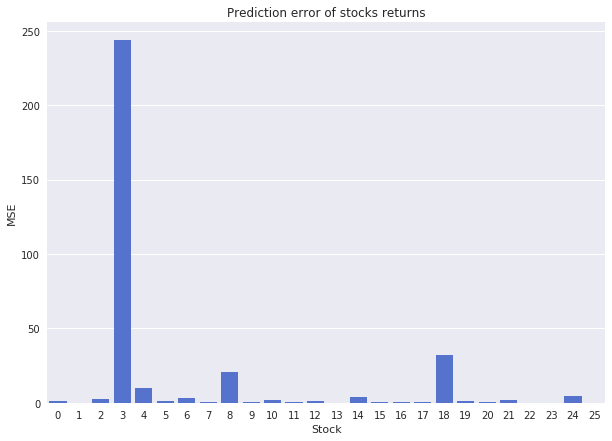

In [27]:
weights = np.array(weights)
losses = []

# compute mean squared error for each stock
for i in range(len(stocksReturns)):
    losses.append(MSE(y_true=stocksReturns[i], 
                      y_pred=weights[i].dot(factor_columns.T)))

sns.barplot(x = np.arange(len(losses)),
            y = losses,
            color = "royalblue")
plt.title("Prediction error of stocks returns")
plt.ylabel("MSE")
plt.xlabel("Stock")
plt.show()

<div class="alert alert-warning" align="justify">
The plot above shows that the model is able to make good predictions for most of the stocks. In order to understand the anomaly of stock number 3 we analyse the real returns and the predicted ones for the stocks with the best and the worst MSE.
</div>

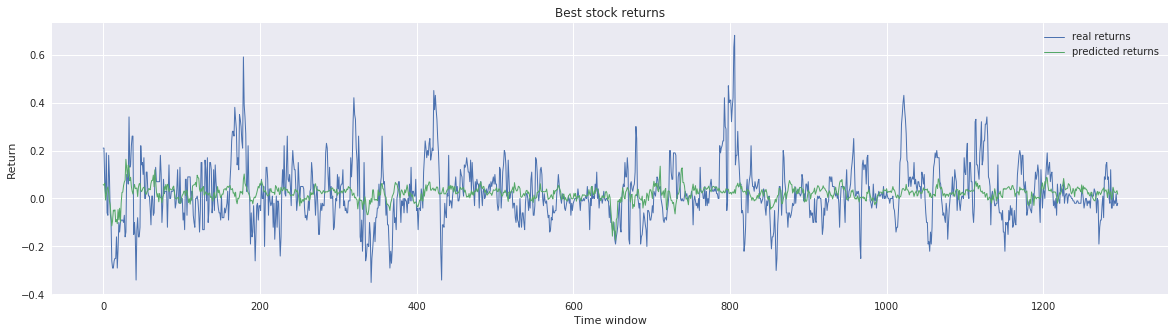

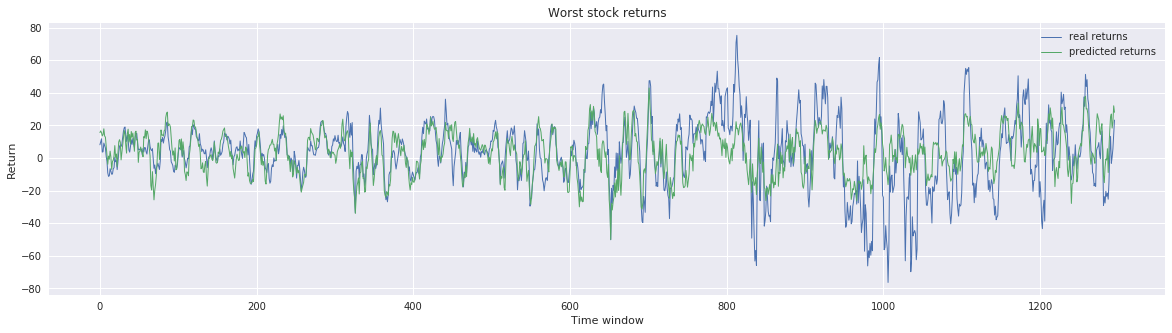

In [28]:
# get the indexes of the stocks with the best and the worst error
maxLossi = np.argmax(losses)
minLossi = np.argmin(losses)

# plot the lowest loss stock returns
returnsBest = stocksReturns[minLossi]
predReturnsBest = weights[minLossi].dot(factor_columns.T)

plt.figure(figsize=(20,5))
plt.plot(returnsBest, lw=1, label="real returns")
plt.plot(predReturnsBest, lw=1, label="predicted returns")

plt.title("Best stock returns")
plt.xlabel("Time window")
plt.ylabel("Return")
plt.legend()
plt.show()

# plot the greatest loss stock returns
returnsWorst = stocksReturns[maxLossi]
predReturnsWorst = weights[maxLossi].dot(factor_columns.T)

plt.figure(figsize=(20,5))
plt.plot(returnsWorst, lw=1, label="real returns")
plt.plot(predReturnsWorst, lw=1, label="predicted returns")

plt.title("Worst stock returns")
plt.xlabel("Time window")
plt.ylabel("Return")
plt.legend()
plt.show()

<div class="alert alert-warning" align="justify">
The two plots seem to give an ambiguous result, this happens because we evaluated predictions using a metric that was not normalized. In the first plot the predicted values don't match the real ones but they are in the range [-0.4, 0.7], therefore the error will be smaller compared to the one in the second plot that displays values in the range [-80, 80].
</div>

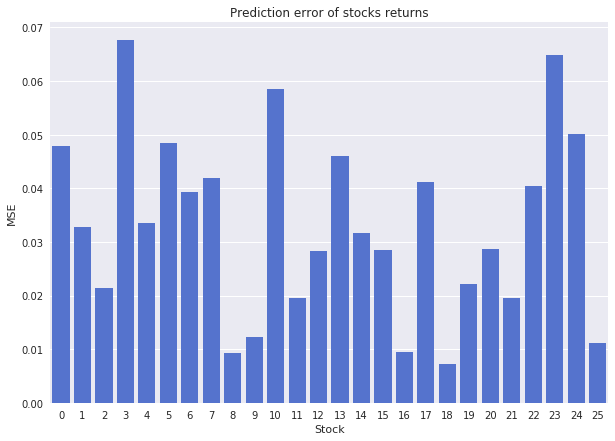

In [29]:
weights = np.array(weights)
losses = []

def normalize(value, minValue, maxValue):
    return (value - minValue) / (maxValue - minValue)

def SquaredError(y_true, y_pred):
    return (y_true - y_pred)**2

# compute the normalized error for each stock
for i in range(len(stocksReturns)):
    # get the list of pairwise errors
    lossList = SquaredError(y_true=stocksReturns[i], 
                            y_pred=weights[i].dot(factor_columns.T))
    
    # normalize the value
    loss = normalize(np.average(lossList), np.min(lossList), np.max(lossList))
    losses.append(loss)

sns.barplot(x = np.arange(len(losses)),
            y = losses,
            color = "royalblue")
plt.title("Prediction error of stocks returns")
plt.ylabel("MSE")
plt.xlabel("Stock")
plt.show()

<div class="alert alert-warning" align="justify">
The final plot shows the correct error values scaled in the range [0, 1]. These values are small enough to prove a fairly good fit of the model on our data.
</div>

### Step 2: Defining the distributions for the market conditions
Since we cannot define the distributions for the market factors directly, we can only approximate their distribution.
The best way to do that, is plotting their value. However, these values may fluctuate quite a lot. 

Next, we show how to use the Kernel density estimation (KDE) technique to approximate such distributions. In brief, kernel density estimation is a way of smoothing out a histogram: this is achieved by assigning (or centering) a probability distribution (usually a normal distribution) to each data point, and then summing. So, a set of two-week-return samples would result in a large number of "super-imposed" normal distributions, each with a different mean. 

To estimate the probability density at a given point, KDE evaluates the PDFs of all the normal distributions at that point and takes their average. The smoothness of a kernel density plot depends on its *bandwidth*, and the standard deviation of each of the normal distributions. For a brief introduction on KDE, please refer to this [link](https://en.wikipedia.org/wiki/Kernel_density_estimation).

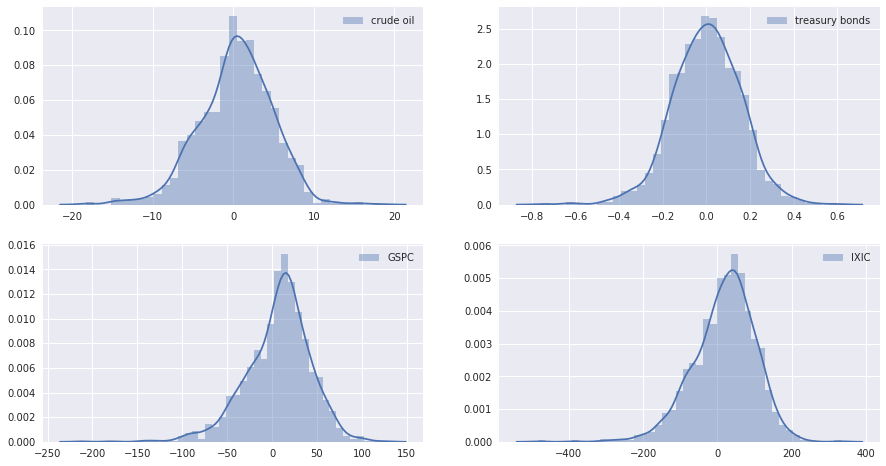

In [30]:
fig, ax = plt.subplots(2, 2, figsize = (15, 8))
for i in range (4):
    sns.distplot(factorsReturns[i], kde=True, ax=ax[int(i/2)][i%2], label=factorsNames[i])
    ax[int(i/2)][i%2].legend()

For the sake of simplicity, we can say that our smoothed versions of the returns of each factor can be represented quite well by a normal distribution. Of course, more exotic distributions, perhaps with fatter tails, could fit more closely the data, but it is outside the scope of this Notebook to proceed in this way.

Now, the simplest way to sample factors returns is to use a normal distribution for each of the factors, and sample from these distributions independently. However, this approach ignores the fact that market factors are often correlated. For example, when the price of crude oil is down, the price of treasury bonds is down too. We can check our data to verify about the correlation.

### Question 6

#### Question 6.1
<div class="alert alert-info">

Calculate the correlation between market factors and explain the result.

</div>

<div class="label label-success">HINT</div> function `np.corrcoef` might be useful.

```python
correlation = ...
correlation
```

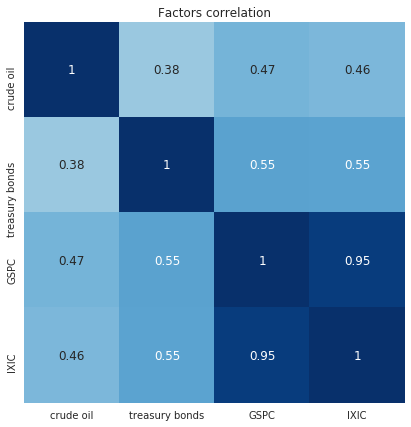

In [31]:
correlation = np.corrcoef(factorsReturns)
correlationDF = pd.DataFrame(data=correlation, columns=factorsNames, index=factorsNames)
ax = sns.heatmap(correlationDF, 
                 vmin = 0, 
                 vmax = 1, 
                 annot = True, 
                 cbar = False, 
                 square = True, 
                 cmap='Blues')
ax.set_title("Factors correlation")
plt.show()

<div class="alert alert-warning" align="justify">
The factors correlations heatmap shows a clear correlation between the GSPC and IXIC market factors, we already expected this result after looking at both the factors trends and their KDE.<br><br>

After some researches, we found out that GSPC is the ticker symbol for the Standard & Poor's 500 (also called S&P 500 or just S&P). It is an American stock market index based on the market capitalizations of 500 large companies having common stock listed on the NYSE or NASDAQ. The S&P 500 index components and their weightings are determined by S&P Dow Jones Indices. It differs from other U.S. stock market indices, such as the Dow Jones Industrial Average or the Nasdaq Composite index, because of its diverse constituency and weighting methodology.<br><br>

Moreover, the IXIC market factor corresponds to the NASDAQ Composite index: a stock market index of the common stocks and similar securities listed on the NASDAQ stock market. Along with the Dow Jones Average and S&P 500 it is one of the three most-followed indices in US stock markets.<br><br>

This knowledge clearly explains the reasons of such great correlation: GSPC and IXIC are market indexes based on the common stocks on the NASDAQ stock market, so their values have different scales mostly because of the different weighting methodology.<br><br>

Since there is no need for highly redundant data in our model we will remove one of the two factors when testing new features combinations. We decided to remove the IXIC index because of its greater scale with respect to the other factors.
</div>

<div class="alert alert-warning" align="justify">
Another way to visualize the correlation between different factors is to use regression plots together with their kde.
</div>

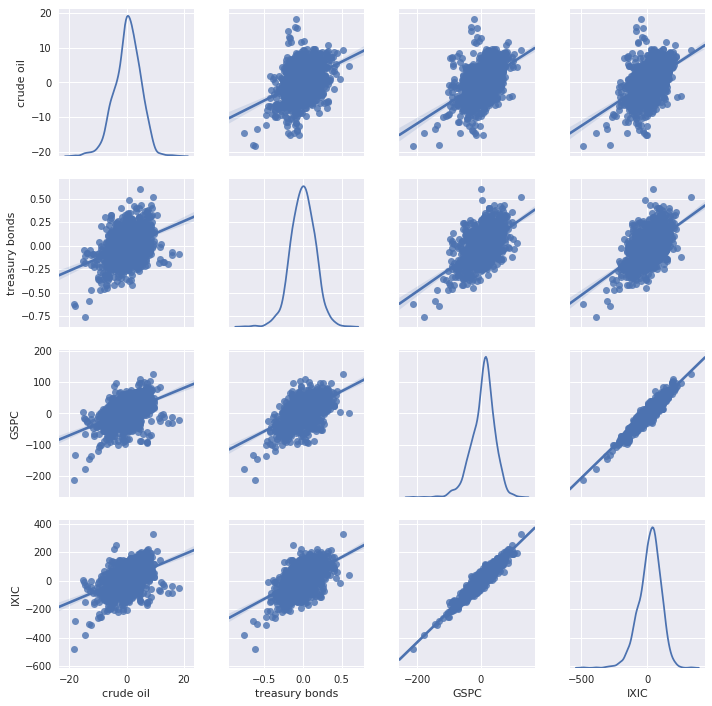

In [32]:
df = pd.DataFrame(np.array(factorsReturns).T, columns=factorsNames)
sns.pairplot(df, kind='reg', diag_kind='kde')
plt.show()

<div class="alert alert-warning" align="justify">
Finally we want to analyse the correlation between model features and stocks to see if there is any clear link between the two variables.
</div>

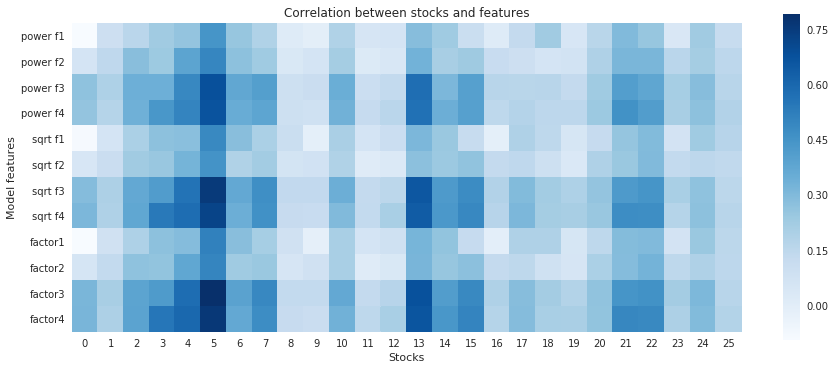

In [33]:
features = np.array(factorFeatures).T
featuresStocksCorrelation = [[pearsonr(feature, stock)[0] for stock in stocksReturns] for feature in features] 
featuresStocksCorrelationDF = pd.DataFrame(data=featuresStocksCorrelation, index=["power f1", "power f2", "power f3", "power f4", 
                                                                                  "sqrt f1",  "sqrt f2",  "sqrt f3",  "sqrt f4", 
                                                                                  "factor1", "factor2", "factor3", "factor4"])
plt.figure(figsize=(15, 6))
ax = sns.heatmap(featuresStocksCorrelationDF, 
                 annot = False, 
                 cbar = True, 
                 square = True, 
                 cmap='Blues')
ax.set_title("Correlation between stocks and features")
ax.set_xlabel("Stocks")
ax.set_ylabel("Model features")
plt.show()

<div class="alert alert-warning" align="justify">
The heatmap shows two main patterns: it is divided in three horizontal almost identical bands and, in each one of these, the last two lines are very similar. The latter is related to the already mentioned high correlation between IXIC and GSPC while the former comes from the dipendence between the three groups of features. <br><br>

The main information coming out of the figure is that most of the stocks have a low correlation with the market factors, an exception is made by stocks 4, 5 and 13 that show higher values. Moreover, it can be noticed that, overall, the stocks are more correlated to the IXIC and GSPC factors than to the crude oil and treasury bonds ones.<br><br>

The low correlation with the first market factors may be due to the fact that crude oil and trasury bonds are generally more stable but it is a good idea to keep them anyway because low fluctuations on those factors may have a big impact on many different stocks.
</div>

The multivariate normal distribution can help here by taking the correlation information between the factors into account. Each sample from a multivariate normal distribution can be thought of as a vector. Given values for all of the dimensions but one, the distribution of values along that dimension is normal. But, in their joint distribution, the variables are not independent.

For this use case, we can write:

$$
\left(\begin{array}{c}f_{1}\\f_{2}\\f_{3}\\f_{4} \end{array}\right)
\sim N 
\left[
  \left(
    \begin{array}{c}
      \mu_1\\ \mu_2 \\ \mu_3 \\ \mu_4 
    \end{array}
  \right), 
  \left(
    \begin{array}{cccc}
      \sigma^2_1 & \rho_{12} \sigma_1\sigma_2 & \rho_{13} \sigma_1\sigma_3 & \rho_{14} \sigma_1\sigma_4 \\ 
      \rho_{12}\sigma_2\sigma_1 & \sigma^2_2 & \rho_{23} \sigma_2\sigma_3 & \rho_{24} \sigma_2\sigma_4\\
      \rho_{13} \sigma_3\sigma_1 & \rho_{23} \sigma_3\sigma_2 & \sigma^2_3 & \rho_{34} \sigma_3\sigma_4 \\ 
      \rho_{14} \sigma_4\sigma_1 & \rho_{24} \sigma_4\sigma_2 & \rho_{34} \sigma_3\sigma_4 & \sigma_4^2 \\ 
    \end{array}
  \right)
\right]
$$

Or,

$$
f_t \sim N(\mu, \sum)
$$

Where $f_1$, $f_2$, $f_3$ and $f_4$ are the market factors, $\sigma_i$ is the standard deviation of factor $i$, $\mu$ is a vector of the empirical means of the returns of the factors and $\sum$ is the empirical covariance matrix of the returns of the factors.

The multivariate normal is parameterized with a mean along each dimension and a matrix describing the covariance between each pair of dimensions. When the covariance matrix is diagonal, the multivariate normal reduces to sampling along each dimension independently, but placing non-zero values in the off-diagonals helps capture the relationships between variables. Whenever having the mean of this multivariate normal distribution and its covariance matrix, we can generate the sample values for market factors.

Next, we will calculate the mean and the covariance matrix of this multivariate normal distribution from the historical data.

#### Question 6.2
<div class="alert alert-info">

Calculate the covariance matrix $\sum$ and the means $\mu$ of factors' returns then generate a random vector of factors return that follows a multivariate normal distribution $\sim N(\mu, \sum)$

</div>

<div class="label label-success">HINT</div>
Function `np.cov` can help calculating covariance matrix. Function `np.random.multivariate_normal(<mean>, <cov>)` is often used for generating samples.

```python
factorCov = ...
factorMeans = [sum(...)/len(...) for ... in ...]
sample = ...
print(factorCov)
print(factorMeans)
print(sample)
```

In [34]:
factorCov = np.cov(factorsReturns)
factorMeans = np.mean(factorsReturns, axis=1)
sample = np.random.multivariate_normal(mean=factorMeans, cov=factorCov)
print("Factors covariance:")
print(factorCov)
print("\nFactors mean:")
print(factorMeans)
print("\nSample from fators multivariate distribution:")
print(sample)

Factors covariance:
[[2.03693782e+01 2.69781721e-01 7.75998548e+01 1.72683995e+02]
 [2.69781721e-01 2.41938403e-02 3.11947099e+00 7.12478010e+00]
 [7.75998548e+01 3.11947099e+00 1.31869736e+03 2.88511836e+03]
 [1.72683995e+02 7.12478010e+00 2.88511836e+03 6.96501404e+03]]

Factors mean:
[3.62361111e-01 1.87962963e-03 6.93776990e+00 1.87289038e+01]

Sample from fators multivariate distribution:
[8.60696315e-01 1.41736299e-02 1.78670564e+01 2.47641621e+01]


<div class="alert alert-warning" align="justify">
In order to visually understand the distribution we are using and its quality it is possible to sample from the multivariate distribution and compare the estimated kde curve with the real ones for each market factor.
</div>

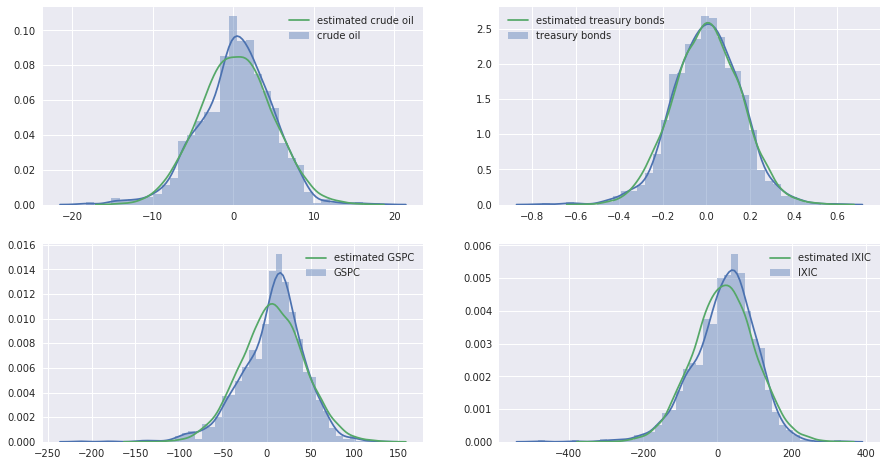

In [35]:
n_samples = 10000
estimatedSamples = np.random.multivariate_normal(mean = factorMeans, 
                                                 cov = factorCov, 
                                                 size = n_samples)
estimatedSamples = estimatedSamples.T

fig, ax = plt.subplots(2, 2, figsize = (15, 8))
estimatedLabels = ["estimated " + name for name in factorsNames]
for i in range (4):
    sns.distplot(factorsReturns[i], kde=True, ax=ax[int(i/2)][i%2], label=factorsNames[i])
    sns.distplot(estimatedSamples[i], kde=True, hist=False, ax=ax[int(i/2)][i%2], label=estimatedLabels[i])
    ax[int(i/2)][i%2].legend()

<div class="alert alert-warning" align="justify">
The resulting distributions give mixed results, on the top line, the real distributions have a good match while for GSPC and IXIC we cannot make the same conclusions.<br><br>

At this point we decide to keep the first two distributions while finding ad hoc distributions for the last two factors. This approach would lead to a better fit of each factor distribution but it would loose the information about the correlation between factors.<br><br>

In the next cells, after the evaluation of this model, we will try to find a compromise: a new multivariate distribution that is elastic enough to have a good fit on all the factors.
</div>

### Step 3&4: Generating samples, running simulation and calculating the VaR

We define some functions that help us calculating VaR 5%. You will see that the functions below are pretty complicated! This is why we provide a solution for you: however, study them well!!

The basic idea of calculating VaR 5% is that we need to find a value such that only 5% of the losses are bigger than it. That means the 5th percentile of the losses should be VaR 5%.

VaR can sometimes be problematic though, since it doesn't give any information on the extent of the losses which can exceed the VaR estimate. CVar is an extension of VaR that is introduced to deal with this problem. Indeed, CVaR measures the expected value of the loss in those cases where VaR estimate has been exceeded.

In [36]:
def fivePercentVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return topLosses[-1]

# an extension of VaR
def fivePercentCVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return sum(topLosses)/len(topLosses)

def bootstrappedConfidenceInterval(
      trials, computeStatisticFunction,
      numResamples, pValue):
    stats = []
    for i in range(0, numResamples):
        resample = trials.sample(True, 1.0)
        stats.append(computeStatisticFunction(resample))
    sorted(stats)
    lowerIndex = int(numResamples * pValue / 2 - 1)
    upperIndex = int(np.ceil(numResamples * (1 - pValue / 2)))
    return (stats[lowerIndex], stats[upperIndex])

Next, we will run the Monte Carlo simulation 10,000 times, in parallel using Spark. Remember to set the parallelism value accordingly.

### Question 7
<div class="alert alert-info">
Complete the code below to define the simulation process and calculate VaR 5%.
</div>

```python
# RUN SILMULATION
def simulateTrialReturns(numTrials, factorMeans, factorCov, weights):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns = ...
        
        # featurize the factors' returns
        trialFeatures = ...
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn = ...
        
        trialReturns.append(trialTotalReturn)
    return trialReturns


        
parallelism = ...
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    ..., ...,
                    ...
                ))
trials.cache()

valueAtRisk = fivePercentVaR(...)
conditionalValueAtRisk = fivePercentCVaR(...)

print "Value at Risk(VaR) 5%:", valueAtRisk
print "Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk
```

In [37]:
def simulateTrialReturns(numTrials, factorMeans, factorCov):
    trialReturns = []
    for i in range(0, numTrials):  
        # generate sample of factors' returns
        trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov)
        
        # featurize the factors' returns
        trialFeatures = featurize(list(trialFactorReturns))
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn = sum(np.array(bFactorWeights.value).dot(trialFeatures))
        
        trialReturns.append(trialTotalReturn)
        
    return trialReturns
        
parallelism = 12
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov
                ))
trials.cache()

PythonRDD[1] at RDD at PythonRDD.scala:48

Value at Risk(VaR) 5%: -36.449898621307824
Conditional Value at Risk(CVaR) 5%: -45.23037490822909


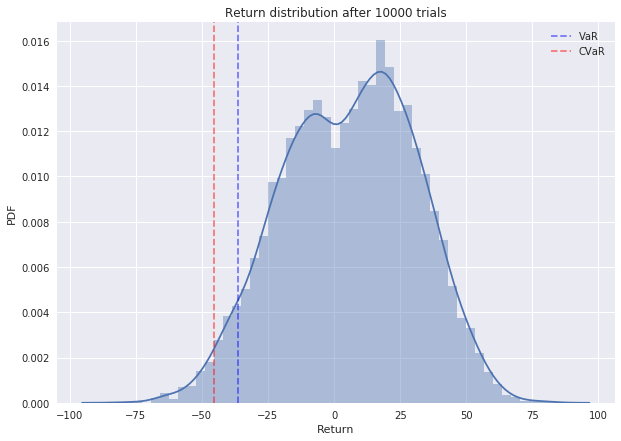

In [38]:
simulations = trials.collect()
valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)

sns.distplot(simulations, kde = True)
plt.axvline(x=valueAtRisk, color='b', ls='--', alpha=0.5, label="VaR")
plt.axvline(x=conditionalValueAtRisk, color='r', ls='--', alpha=0.5, label="CVaR")
plt.title("Return distribution after {} trials".format(numTrials))
plt.xlabel("Return")
plt.ylabel("PDF")
plt.legend()
plt.show()

The value of VaR depends on how many invested stocks and the chosen distribution of random variables. Assume that we get VaR 5% = -2.66,  that means that there is a 0.05 probability that the portfolio will fall in value by more than \$2.66 over a two weeks' period if there is no trading. In other words, the loses are less than \$2.66 over two weeks' period with 95% confidence level. When a loss over two weeks is more than \$2.66, we call it **failure** (or **exception**). Informally, because of 5% probability, we expect that there are only $0.05*W$ failures out of total $W$ windows.

### Step 5: Evaluating the results using backtesting method
In general, the error in a Monte Carlo simulation should be proportional to 1/sqrt(n), where n is the number of trials. This means, for example, that quadrupling the number of trials should approximately cut the error in half. A good way to check the quality of a result is backtesting on historical data. Backtesting is a statistical procedure where actual losses are compared to the estimated VaR. For instance, if the confidence level used to calculate VaR is 95% (or VaR 5%), we expect only 5 failures over 100 two-week time windows.

The most common test of a VaR model is counting the number of VaR failures, i.e., in how many windows, the losses exceed VaR estimate. If the number of exceptions is less than selected confidence level would indicate, the VaR model overestimates the risk. On the contrary, if there are too many exceptions, the risk is underestimated. However, it's very hard to observe the amount of failures suggested by the confidence level exactly. Therefore, people try to study whether the number of failures is reasonable or not, or will the model be accepted or rejected.

One common test is Kupiec's proportion-of-failures (POF) test. This test considers how the portfolio performed at many historical time intervals and counts the number of times that the losses exceeded the VaR. The null hypothesis is that the VaR is reasonable, and a sufficiently extreme test statistic means that the VaR estimate does not accurately describe the data. The test statistic is computed as:

$$
-2ln\Bigg(\frac{(1-p)^{T-x}p^x}{(1-\frac{x}{T})^{T-x}(\frac{x}{T})^x}\Bigg)
$$

where:

$p$ is the quantile-of-loss of the VaR calculation (e.g., in VaR 5%, p=0.05),

$x$ (the number of failures) is the number of historical intervals over which the losses exceeded the VaR 

$T$ is  the total number of historical intervals considered

Or we can expand out the log for better numerical stability:

$$
\begin{equation}
-2\Big((T-x)ln(1-p)+x*ln(p)-(T-x)ln(1-\frac{x}{T})-x*ln(\frac{x}{T})\Big)
\end{equation}
$$

If we assume the null hypothesis that the VaR is reasonable, then this test statistic is drawn from a chi-squared distribution with a single degree of freedom. By using Chi-squared distribution, we can find the `p-value` accompanying our test statistic value.  If `p-value` exceeds the critical value of the Chi-squared distribution, we do have sufficient evidence to reject the null hypothesis that the model is reasonable. Or we can say, in that case, the model is considered as inaccurate.

For example, assume that we calculate VaR 5% (the confidence level of the VaR model is 95%) and get value VaR = 2.26. We also observed 50 exceptions over 500 time windows. Using the formula above, the test statistic `p-value` is calculated and equal to `8.08`. Compared to `3.84`, the critical value of Chi-squared distribution with one degree of freedom at probability 5%, the test statistic is larger. So, the model is rejected. The critical values of Chi-squared can be found by following [this link](https://people.richland.edu/james/lecture/m170/tbl-chi.html).
However, in this Notebook, it's not a good idea to find the corresponding critical value by looking in a "messy" table, especially when we need to change the confidence level. Instead, from `p-value`, we will calculate the probability of the test statistic in Chi-square thanks to some functions in package `scipy`. If the calculated probability is smaller than the quantile of loss (e.g, 0.05), the model is rejected and vice versa.


### Question 8

#### Question 8.1
<div class="alert alert-info">

Write a function to calculate the number of failures, that is when the losses (in the original data) exceed the VaR.

</div>

<div class="label label-success">HINT</div>
<ul>
  <li>First, we need to calculate the total loss in each 2-week time interval</li>
  <li>If the total loss of a time interval exceeds VaR, then we say that our VaR fails to estimate the risk in that time interval</li>
  <li>Return the number of failures</li>
</ul>  

<div class="label label-danger">NOTE</div> The loss is often having negative value, so, be careful when compare it to VaR.

```python
from scipy import stats
import math

def countFailures(stocksReturns, valueAtRisk):
    failures = 0
    # iterate over time intervals
    for i in range(0, ...):
        # calculate the losses in each time interval
        loss = ...
        
        # if the loss exceeds VaR
        if ...:
            failures += 1
    return failures
```

In [39]:
def countFailures(stocksReturns, valueAtRisk):
    failures = 0
    # iterate over time intervals
    for i in range(0, len(stocksReturns[0])):
        # calculate the losses in each time interval
        loss = np.sum([x[i] for x in stocksReturns])
        
        # if the loss exceeds VaR
        if loss < valueAtRisk:
            failures += 1
    return failures

#### Question 8.2
<div class="alert alert-info">

Write a function named `kupiecTestStatistic` to calculate the test statistic which was described in the above equation.

</div>

```python
def kupiecTestStatistic(total, failures, confidenceLevel):
    failureRatio = .../...
    logNumer = ...
    logDenom = ...
    return -2 * (logNumer - logDenom)
    
# test the function
assert (round(kupiecTestStatistic(250, 36, 0.1), 2) == 4.80), "function kupiecTestStatistic runs incorrectly"
```

In [40]:
def kupiecTestStatistic(total, failures, confidenceLevel):
    failureRatio = max(failures / total, sys.float_info.min) # sys.float_info.min avoids np.log exception if failureRatio == 0
    logNumer = (total - failures) * np.log(1 - confidenceLevel) + failures * np.log(confidenceLevel)
    logDenom = (total - failures) * np.log(1 - failureRatio) + failures * np.log(failureRatio)
    return -2 * (logNumer - logDenom)
# test the function
assert (round(kupiecTestStatistic(250, 36, 0.1), 2) == 4.80), "function kupiecTestStatistic runs incorrectly"

Now we can find the p-value accompanying our test statistic value.

In [41]:
def kupiecTestPValue(stocksReturns, valueAtRisk, confidenceLevel):
    failures = countFailures(stocksReturns, valueAtRisk)
    total = len(stocksReturns[0])
    N = len(stocksReturns)
    testStatistic = kupiecTestStatistic(total, failures, confidenceLevel)
    failurePerc = failures * 100 / total
    #return 1 - stats.chi2.cdf(testStatistic, 1.0)
    return stats.chi2.sf(testStatistic, 1.0), failurePerc

varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
pValue, failPerc = kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)
print("VaR confidence interval: " , varConfidenceInterval)
print("CVaR confidence interval: " , cvarConfidenceInterval)
print("Failure percentage: " , failPerc, "%")
print("Kupiec test p-value: " , pValue)

VaR confidence interval:  (-36.2498244152943, -36.076785491870574)
CVaR confidence interval:  (-45.439188371235325, -46.31514462020685)
Failure percentage:  9.49074074074074 %
Kupiec test p-value:  3.198082540345584e-11


#### Question 8.3
<div class="alert alert-info">

Discuss the results you have obtained

</div>

<div class="alert alert-warning">
Looking at the results, it seems that our model is not as good as we may have expected. The Kupiec p-value test returns a value extremely lower that our VaR percentile and thus the model should be rejected. The p-value obtained is in line with the POF, which was supposed to be around 5% and it floats instead around 9.8.<br><br>

The reasons for these results can be various, for example we could not have considered some market factors (or considered the wrong ones), or we could have assumed a wrong distribution for them. Altough we can't do much for the first of the two possible causes, we can try to improve our model by finding a distribution that better fits our data.<br><br>

A first analysis of the results tells that we are underestimating the risk, maybe because, using a multivariate normal, we are non giving enough probability to the big losses represented by the tails of the distribution.<br>
With this in mind, we may want to consider the t-student distribution instead of the normal, since the former typically presents heavier tails. A more detailed analysis of the possible distributions of the market factors will be performed in 'Question 10'.
</div>

### Question 9
<div class="alert alert-info">
Assume that we invest in more than 100 stocks. Use the same market factors as for the previous questions to estimate VaR by running MCS, then validate your result.  

What is the main observation you have, once you answer this question? When you plan to invest in more instruments, how is your ability to predict the risk going to be affected?
</div>

In [42]:
def getVaR(nFiles, 
          factor_columns, 
          factorMeans,
          factorCov,
          start,
          end,
          nYears = 5,
          nTrials = 10000):
    
    # get stocks history files and convert them into lists
    files = [join(stock_folder, f) for f in sorted(listdir(stock_folder)) if isfile(join(stock_folder, f))]
    files = files[:nFiles]
    rawStocks = [process_stock_file(f) for f in files]

    # select only stocks having nYears of history and values between start and end
    rawStocks = list(filter(lambda instrument: len(instrument) >= number_of_years * 260 and
                                                instrument[0][0] <= start and 
                                                instrument[-1][0] >= end,
                            rawStocks))
    
    # trim the time region from start to end and fill missing values
    stocks = list(map(lambda stock: \
                fillInHistory(
                    trimToRegion(stock, start, end), 
                start, end + timedelta(days=1)), 
            rawStocks))
    
    # get two-week returns
    stocksReturns = list(map(twoWeekReturns, stocks))

    # estimate weights
    weights = [estimateParams(ret, factor_columns) for ret in stocksReturns]

    # run Monte Carlo simulations
    parallelism = 12
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)
    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns(
                        max(int(nTrials/parallelism), 1), 
                        factorMeans, factorCov
                    ))
    trials.cache()

    # get VaR and CVaR
    valueAtRisk = fivePercentVaR(trials)
    conditionalValueAtRisk = fivePercentCVaR(trials)

    # validate results
    varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
    cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
    pValue, failPerc = kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)
    
    return [valueAtRisk, conditionalValueAtRisk], [varConfidenceInterval, cvarConfidenceInterval], [pValue, failPerc]

In [43]:
VaRs, confs, pVal = getVaR(nFiles = 100, 
                          factor_columns = factor_columns, 
                          factorMeans = factorMeans,
                          factorCov = factorCov,
                          start = start,
                          end = end)

print("Value at Risk(VaR) 5%:", VaRs[0])
print("Conditional Value at Risk(CVaR) 5%:", VaRs[1])

print("VaR confidence interval: " , confs[0])
print("CVaR confidence interval: " , confs[1])

print("Failure percentage: " , pVal[1], " %")
print("Kupiec test p-value: " , pVal[0])

Value at Risk(VaR) 5%: -35.84960607416694
Conditional Value at Risk(CVaR) 5%: -44.29197529892
VaR confidence interval:  (-35.66839127366112, -35.769985734289)
CVaR confidence interval:  (-43.99597796016915, -44.82803267942948)
Failure percentage:  20.37037037037037  %
Kupiec test p-value:  4.6392698441233445e-84


<div class="alert alert-warning">
The previous model already gave poor results therefore increasing the number of instruments can only have a negative influence on the estimation of the VaR, especially if we do not increase the number of market factors as well.<br>
The results of the MC simulation prove what just stated: although the VaR still floats around 34.8, more than 20% of the stockReturns exceeded that value and the Kupiec p-value is far away from the 0.05 we were looking for.
</div>

### Question 10
<div class="alert alert-info">

In the previous questions, we used the normal distributions to sample the factors returns.  

Try to study how results vary when selecting other probability distributions: our goal is to improve the result of our MCS.
</div>

#### Question 10.1: Q-Q Plot

<div class="alert alert-warning" align="justify">
The Quantile-Quantile plot is a visual tool that provides an easy-to-interpret measure of how well a distribution fits a dataset. The x-axis of the plot represents the teoretical data distribution for the pdf we're tring to fit. The y-axis instead is the real data distibution.<br>
Ideally, if the dataset perfectly matches the distribution that is beeing examined, all the points from theoretical (x-axis) and real (y-axis) data will coincide and thus all the points of the plot will reside on the line `y=x`. When this is not the case, the shape of the plot, in particular the tails, provides information on the statistical dispersion of the actual data with respect to the theoretical distribution. If the plot is steeper than `y=x` (i.e. derivative > 1) it means that our data follow a more dispersed distribution. The opposite (i.e. more flatter plot) denotes a less dispersed distribution of the data.<br>
</div>
<div class="alert alert-warning" align="justify">
We will now exploit this tool to find the best distribution for each factor.
</div>

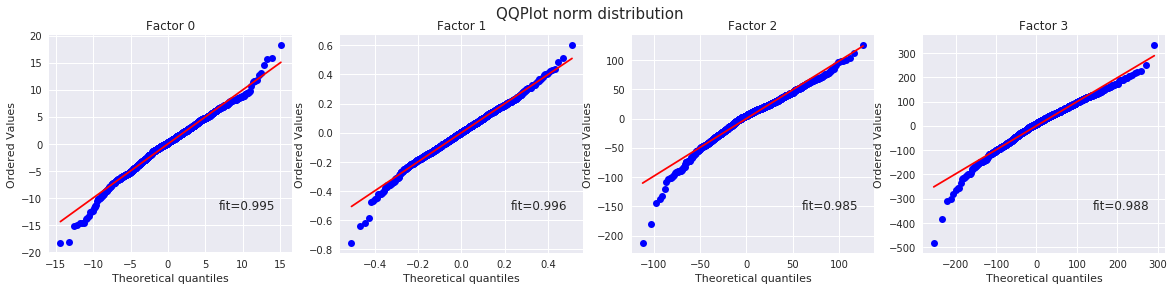

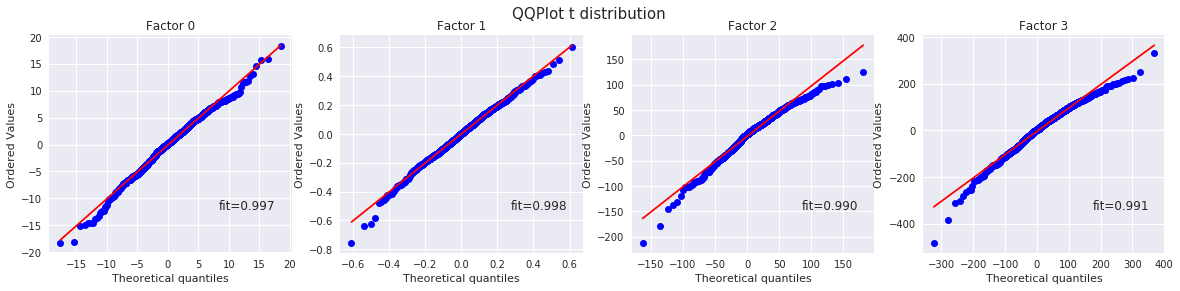

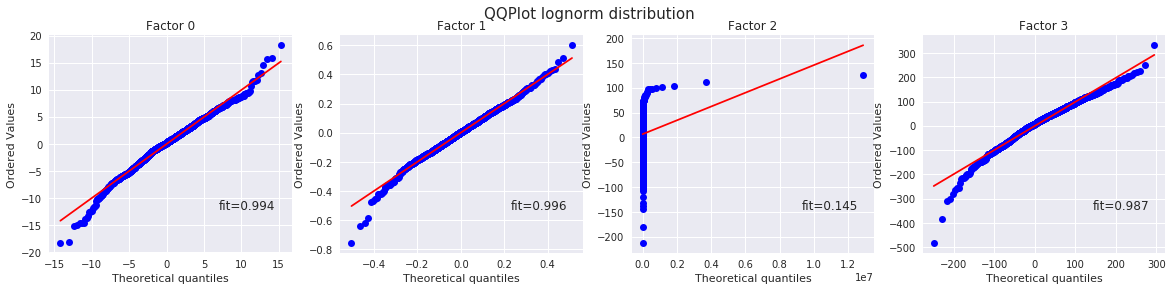

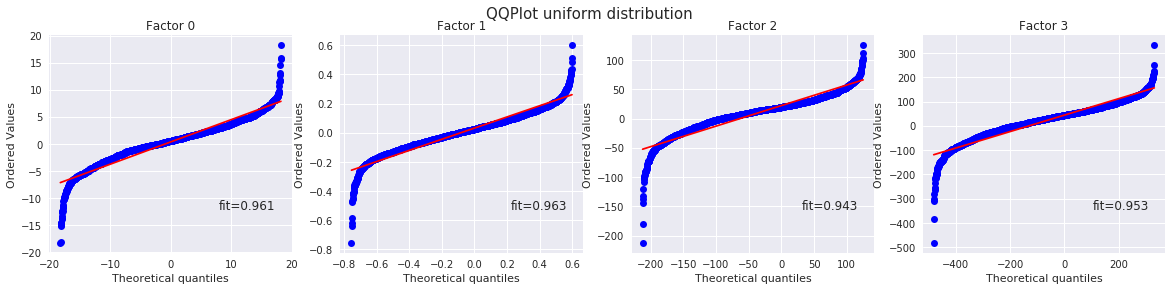

In [44]:
distr_params_dic = {}

for dist_name in ["norm", "t", "lognorm", "uniform"]:
    fig, ax = plt.subplots(1, len(factorsReturns), figsize = (20, 4))
    param_list = []
    for i in range(len(factorsReturns)):
        # Fit the distribution to the data. The function will try to get the best parameters 
        # configuration for the current distribution (e.g. mean and sigma for a normal distribution)
        dist = getattr(scipy.stats, dist_name)
        params = dist.fit(factorsReturns[i])
        
        # Store parameters for later use
        param_list.append(params)
        
        # Plot the Q-Q plot
        _, fit = stats.probplot(factorsReturns[i], dist = dist(*params), plot = ax[i])
        ax[i].set_title("Factor " + str(i))
        y_lim = ax[i].get_ylim()
        x_lim = ax[i].get_xlim()
        ax[i].annotate('fit={0:.3f}'.format(fit[2]), xy=(0.7*x_lim[1] + 0.3*x_lim[0], 0.8*y_lim[0] + 0.2*y_lim[1]))
        
    distr_params_dic[dist_name] = param_list
    plt.suptitle("QQPlot {} distribution".format(dist_name), size=15)
    plt.show()

<div class="alert alert-warning" align="justify">
Recalling the distributions estimated in "section 5.6 - step 2", the Q-Q plots show exaclty what we expected: the normal is indeed a good approssimation of the distribution for all the factors, but still, it lacks in dispersion, since our data seem to present steeper tails.<br><br>

The t-student distribution, as already hypothesized in 8.3, is the best match for all these factors (highest fit value) because it is able to adapt its shape to the heavy tails.<br><br>

The log-normal distribution is supposed to be more squeezed with respect to the gaussian, but even if gaussian fits better our data, the log-normal has a surprisingly good match.<br><br>

The uniform distribution has been plotted to show an extreme case: in fact it does not present any tails at all and that's why we have very steep tails in all the QQplots.
</div>

#### Question 10.2: evaluate other distributions

<div class="alert alert-warning" align="justify">
The following methods are a re-definition of functions used before, with an extra parameter that will allow us to change the distribution to be applied to the factors.
</div>

In [45]:
def simulateTrialReturns_generic(numTrials, distribution_func, args, weights, feature_fun = featurize):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
    
        trialFactorReturns = distribution_func(*args)
        
        # featurize the factors' returns
        trialFeatures = feature_fun(list(trialFactorReturns))
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn = sum(np.array(weights).dot(trialFeatures))
        
        trialReturns.append(trialTotalReturn)
    return trialReturns

In [46]:
def getVaR_generic(nFiles, 
          factor_columns, 
          start,
          end,
          distribution_func,
          func_args, 
          feature_fun = featurize,
          nYears = 5,
          nTrials = 10000
          ):
    
    # get stocks history files and convert them into lists
    files = [join(stock_folder, f) for f in sorted(listdir(stock_folder)) if isfile(join(stock_folder, f))]
    files = files[:nFiles]
    rawStocks = [process_stock_file(f) for f in files]

    # select only stocks having nYears of history and values between start and end
    rawStocks = list(filter(lambda instrument: len(instrument) >= number_of_years * 260 and
                                                instrument[0][0] <= start and 
                                                instrument[-1][0] >= end,
                            rawStocks))
    
    # trim the time region from start to end and fill missing values
    stocks = list(map(lambda stock: \
                fillInHistory(
                    trimToRegion(stock, start, end), 
                start, end + timedelta(days=1)), 
            rawStocks))

    # get two-week returns
    stocksReturns = list(map(twoWeekReturns, stocks))

    # estimate weights
    weights = [estimateParams(ret, factor_columns) for ret in stocksReturns]
    
    # run Monte Carlo simulations
    parallelism = 12
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)
    
    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns_generic(
                        max(int(nTrials/parallelism), 1), 
                        distribution_func, func_args,
                        bFactorWeights.value,
                        feature_fun = feature_fun
                    ))
    trials.cache()

    # get VaR and CVaR
    valueAtRisk = fivePercentVaR(trials)
    conditionalValueAtRisk = fivePercentCVaR(trials)

    # validate results
    varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
    cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, 0.05)
    pValue, failPerc = kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)
    
    return [valueAtRisk, conditionalValueAtRisk], [varConfidenceInterval, cvarConfidenceInterval], [pValue, failPerc]

<div class="alert alert-warning" align="justify">
Considering the interpretation of the Q-Q plots above, we will now try to evaluate the model assuming a t-student distribution for the factors. The following code defines a multivariate t-student distribution from the associate normal.
</div>

In [47]:
# Student's T random variable
def t_student_dist_multi(m, S, df=np.inf):
    '''generate random variables of multivariate t distribution
    Parameters
    ----------
    m : array_like
        mean of random variable, length determines dimension of random variable
    S : array_like
        square array of covariance  matrix
    df : int or float
        degrees of freedom
    Returns
    -------
    rvs : ndarray
        draw of a multivariate t distributed random variable
    '''
    m = np.asarray(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df)/df
    z = np.random.multivariate_normal(m,S)

    return z/np.sqrt(x)

<div class="alert alert-warning" align="justify">
The t-student distribution shape is influenced by a parameter called "degree of freedom" $df$. It strongly influences the dispersion, in a way that, the bigger it is, the less dispersed is the distribution. As $df\rightarrow\infty$ the t-student distribution becomes equivalent to a gaussian.<br>
To find the best value, we will now run the algorithm with different $df$.
</div>

In [48]:
v_list = []
cv_list = []
v_conf_list = []
cv_conf_list = []
pof_list = []
p_list = []
dfs = list(range(1,10)) + [np.inf]
for df in dfs:
    VaRs, confs, pVal = getVaR_generic(nFiles = 35, 
                               factor_columns = factor_columns, 
                               start = start,
                               end = end,
                               distribution_func = t_student_dist_multi,
                               func_args = (factorMeans, factorCov, df)
                              )
    v_list.append(VaRs[0])
    cv_list.append(VaRs[1])
    v_conf_list.append(confs[0])
    cv_conf_list.append(confs[1])
    pof_list.append(pVal[1])
    p_list.append(pVal[0])

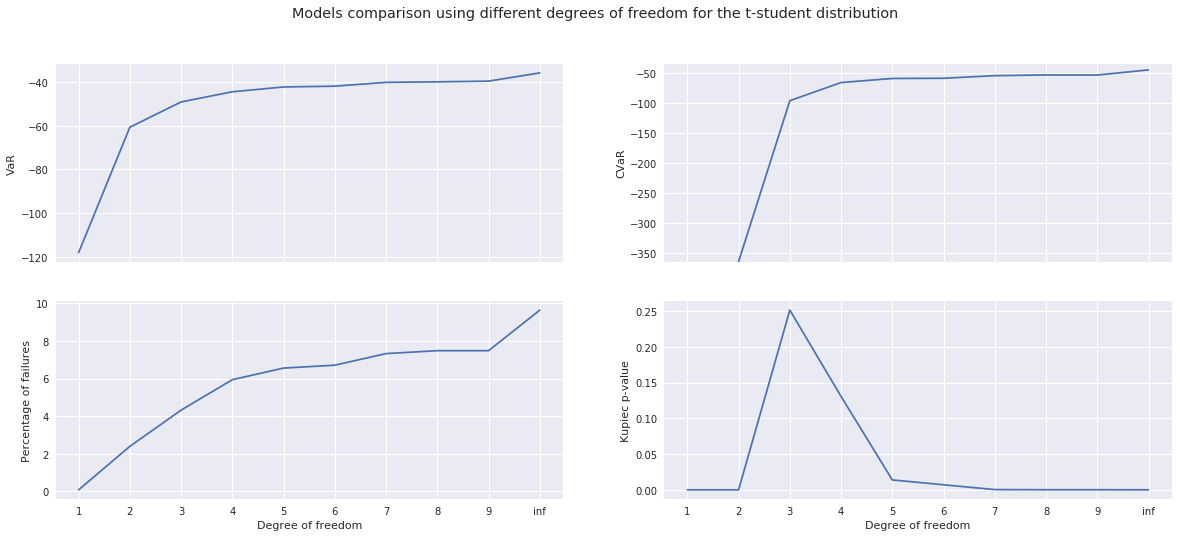

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(20, 8), sharex=True)
x_ticks = [str(x) for x in dfs]

# Plot VaRs vs DF
ax[0][0].plot(range(len(dfs)), v_list)
ax[0][0].set(ylabel = 'VaR')
ax[0][0].set_xticks(range(len(dfs)))
ax[0][0].set_xticklabels(x_ticks)

# Plot CVaRs vs DF
ax[0][1].plot(range(len(dfs)), cv_list)
ax[0][1].set(ylabel = 'CVaR', ylim=(cv_list[1], cv_list[-1]+10))
ax[0][1].set_xticks(range(len(dfs)))
ax[0][1].set_xticklabels(x_ticks)

# Plot Percentages of Failures vs DF
ax[1][0].plot(range(len(dfs)), pof_list)
ax[1][0].set(xlabel = 'Degree of freedom', ylabel = 'Percentage of failures')
ax[1][0].set_xticks(range(len(dfs)))
ax[1][0].set_xticklabels(x_ticks)

# Plot Kupiec p-value vs DF
ax[1][1].plot(range(len(dfs)), p_list)
ax[1][1].set(xlabel = 'Degree of freedom', ylabel = 'Kupiec p-value')
ax[1][1].set_xticks(range(len(dfs)))
ax[1][1].set_xticklabels(x_ticks)

plt.suptitle("Models comparison using different degrees of freedom for the t-student distribution")
plt.show()    

<div class="alert alert-warning" align="justify">
The plots show good results for $df=3$. It's interesting to notice how the VaR and the PoF are monotonic functions of $df$: this is quickly explained if we consider that we are tring to use t-student distribution because the normal distribution seemed to under-estimate the risk, and indeed a t-student distribution behaves more like a gaussian while increasing the degrees of freedom.
</div>
<div class="alert alert-warning" align="justify">
Finally, let's compare the models with normal and t-student multivariate distribution.
</div>

In [50]:
best = 2
print("------ T-student multivariate ------")
print("Value at Risk(VaR) 5%:", v_list[best])
print("Conditional Value at Risk(CVaR) 5%:", cv_list[best])

print("VaR confidence interval: " , v_conf_list[best])
print("CVaR confidence interval: " , cv_conf_list[best])

print("Failure percentage: " , pof_list[best], " %")
print("Kupiec test p-value: " , p_list[best])

print()

print("------ Normal multivariate ------")
print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)

print("VaR confidence interval: " , varConfidenceInterval)
print("CVaR confidence interval: " , cvarConfidenceInterval)

print("Failure percentage: " , failPerc, "%")
print("Kupiec test p-value: " , pValue)

------ T-student multivariate ------
Value at Risk(VaR) 5%: -49.11583662783048
Conditional Value at Risk(CVaR) 5%: -95.90324992985745
VaR confidence interval:  (-49.252946950740885, -46.178629565196104)
CVaR confidence interval:  (-107.44407892225176, -89.1337376529023)
Failure percentage:  4.320987654320987  %
Kupiec test p-value:  0.2513273178296842

------ Normal multivariate ------
Value at Risk(VaR) 5%: -36.449898621307824
Conditional Value at Risk(CVaR) 5%: -45.23037490822909
VaR confidence interval:  (-36.2498244152943, -36.076785491870574)
CVaR confidence interval:  (-45.439188371235325, -46.31514462020685)
Failure percentage:  9.49074074074074 %
Kupiec test p-value:  3.198082540345584e-11


<div class="alert alert-warning" align="justify">
The t-student distribution strongly improves the model. While with the normal the normal distribution we had to reject the model due to a too low p-value, with the t-student distribution the p-value metric gives a positive outcome. Also, the percentage of failure suggests that the new model is acceptable, since it is very close to our confidence level of the VaR 5%.
</div>

## 6. Further Experiments

<div class="alert alert-warning" align="justify">
As already stated in this notebook, the choice of the features for our model can be improved in two ways: we may want to remove the IXIC index because of its high correlation with the GSPC market factor and use different additional features.<br><br>

An interesting choice for the new features could be the use cross-factors features: each new feature is the product of two already existing market factors. Since we will remove one factor we know that, in this case, this approach will lead to the addition of just three new features while, if we had more market factors, a huge amount of new features could have been created and, therefore, some "features filtering" would have been necessary.
</div>

In [51]:
# remove the IXIC market factor
factorsReturns = factorsReturns[:3]

# implement new featurize function
def crossFeaturize(factorReturns):
    crossFeatures = []
    for i, x in enumerate(factorReturns[:-1]):
        crossFeatures += [x * y for y in factorReturns[i+1:]]
        
    return crossFeatures + factorReturns

# test our function
assert (crossFeaturize([1, 2, 3]) == [2, 3, 6, 1, 2, 3]), "Function runs incorrectly"

In [52]:
def estimateParams(y, x):
    return sm.OLS(y, x).fit().params

# transpose factorsReturns
factorMat = transpose(factorsReturns)

# featurize each row of factorMat
modelFeatures = list(map(crossFeaturize, factorMat))

# OLS require parameter is a numpy array
modelFeatures = np.array(modelFeatures)

#add a constant - the intercept term for each instrument i.
modelFeatures = sm.add_constant(modelFeatures, prepend=True)

# estimate weights
weights = [estimateParams(ret, modelFeatures) for ret in stocksReturns]

print("The stocks returns matrix has shape: [" + str(len(stocksReturns)) + " x " + str(len(stocksReturns[0])) + "]")
print("The transposed factors returns matrix has shape: [" + str(len(factorMat)) + " x " + str(len(factorMat[0])) + "]")
print("The features matrix has shape: [" + str(len(modelFeatures)) + " x " + str(len(modelFeatures[0])) + "]")
print("The weights matrix has shape: [" + str(len(weights)) + " x " + str(len(weights[0])) + "]")

The stocks returns matrix has shape: [26 x 1296]
The transposed factors returns matrix has shape: [1296 x 3]
The features matrix has shape: [1296 x 7]
The weights matrix has shape: [26 x 7]


<div class="alert alert-warning" align="justify">
As expected the dimensions of the matrices changed: the factor returns matrix has one less column because we removed one market factor, and the features matrix has 7 columns because we added three new features and the intercept term to the already existing three market factors.<br><br>

Let's look again at the correlation heatmap between the stocks returns and the new features and run the model.
</div>

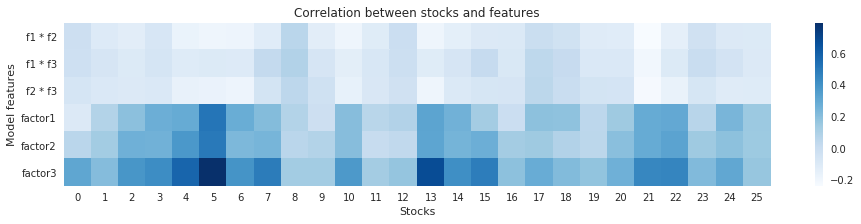

In [53]:
# do not consider the intercept term
features = modelFeatures.T[1:]
featuresStocksCorrelation = [[pearsonr(feature, stock)[0] for stock in stocksReturns] for feature in features] 
featuresStocksCorrelationDF = pd.DataFrame(data=featuresStocksCorrelation, index=["f1 * f2", "f1 * f3", "f2 * f3",
                                                                                  "factor1", "factor2", "factor3"])
plt.figure(figsize=(16, 3))
ax = sns.heatmap(featuresStocksCorrelationDF, 
                 annot = False, 
                 cbar = True, 
                 square = True, 
                 cmap='Blues')
ax.set_title("Correlation between stocks and features")
ax.set_xlabel("Stocks")
ax.set_ylabel("Model features")
plt.show()

In [59]:
factorCov = np.cov(factorsReturns)
factorMeans = np.mean(factorsReturns, axis=1)

VaRs, confs, pVal = getVaR_generic(nFiles = 35, 
                                   factor_columns = modelFeatures, 
                                   start = start,
                                   end = end,
                                   distribution_func = t_student_dist_multi,
                                   feature_fun = crossFeaturize,
                                   func_args = (factorMeans, factorCov, 2)
                                  )

print("------ Cross-features ------")

print("Value at Risk(VaR) 5%:", VaRs[0])
print("Conditional Value at Risk(CVaR) 5%:", VaRs[1])

print("VaR confidence interval: " , confs[0])
print("CVaR confidence interval: " , confs[1])

print("Failure percentage: " , pVal[1], " %")
print("Kupiec test p-value: " , pVal[0])

------ Cross-features ------
Value at Risk(VaR) 5%: -51.04253860276554
Conditional Value at Risk(CVaR) 5%: -114.98976644093567
VaR confidence interval:  (-50.6011924252095, -50.95917784432917)
CVaR confidence interval:  (-113.64021629740348, -130.21920737747152)
Failure percentage:  4.012345679012346  %
Kupiec test p-value:  0.0915914059315136


<div class="alert alert-warning" align="justify">
This final model can be accepted too given its results. It can be noticed how both the failure percentage and the p-value decreased giving us a different trade-off with respect to the old model.<br>
A final remark has to be made about this slight change over the metrics measuring the quality of the model, the new features did not impact the model very much because they are coming from the same market factors and the model keeps his good results mainly due to the good distribution used to model these factors.
</div>

# 7. Summary
In this lecture, we studied the Monte Carlo Simulation method and its application to estimate financial risk. To apply it, first, we needed to define the relationship between market factors and the instruments' returns. In such step, you must define the model which maps the market factors' values to the instruments' values: in our use case, we used a linear regression function for building our model. Next, we also had to find the parameters of our model, which are the weights of the factors we considered. Then, we had to study the distribution of each market factor. A good way to do that is using Kernel density estimation to smooth the distribution and plot it. Depending on the shape of each figure, we had to guess the best fit distribution for each factor: in our use case, we used a very simple approach, and decided that our smoothed distributions all looked normal distributions. 

Then, the idea of Monte Carlo simulation was to generate many possible values for each factor and calculate the corresponding outcomes by a well-defined model in each trial. After many trials, we were able to calculate VaR from the sequences of outcome's values. When the number of trials is large enough, the VaR converges to reasonable values, that we could validate using well-known statistical hypothesis. 

# References
- The example in section 2 is inspired from [this article](http://www.solver.com/monte-carlo-simulation-example).
- [Backtesting Value-at-Risk models](https://aaltodoc.aalto.fi/bitstream/handle/123456789/181/hse_ethesis_12049.pdf?sequence=1) (Kansantaloustiede, 2009) - (A good reference to study Backtesting).
